# Project 2 - Classification and Regression -- 2013/2014 CitiBike-NYC Data
**Michael Smith, Alex Frye, Chris Boomhower ----- 3/08/2017**

<img src="https://github.com/msmith-ds/DataMining/blob/master/Project2_Full/Images/Citi-Bike.jpg?raw=true" width="400">

<center>Image courtesy of http://newyorkeronthetown.com/, 2017</center>

### Introduction
*** Describe the purpose of the model you are about to build ***

The data set again selected by our group for Lab 2 consists of [Citi Bike trip history](https://www.citibikenyc.com/system-data) data collected and released by NYC Bike Share, LLC and Jersey Bike Share, LLC under Citi Bike's [NYCBS Data Use Policy](https://www.citibikenyc.com/data-sharing-policy). Citi Bike is America's largest bike share program, with 10,000 bikes and 600 stations across Manhattan, Brooklyn, Queens, and Jersey City... 55 neighborhoods in all. As such, our data set's trip history includes all rental transactions conducted within the NYC Citi Bike system from July 1st, 2013 to February 28th, 2014. These transactions amount to 5,562,293 trips within this time frame. The original data set includes 15 attributes. In addition to these 15, our team was able to derive 15 more attributes for use in our classification efforts, some attributes of which are NYC weather data which come from [Carbon Dioxide Information Analysis Center (CDIAC)](http://cdiac.ornl.gov/cgi-bin/broker?_PROGRAM=prog.climsite_daily.sas&_SERVICE=default&id=305801&_DEBUG=0). These data are merged with the Citi Bike data to provide environmental insights into rider behavior.

The trip data was collected via Citi Bike's check-in/check-out system among 330 of its stations in the NYC system as part of its transaction history log. While the non-publicized data likely includes further particulars such as rider payment details, the publicized data is anonymized to protect rider identity while simultaneously offering bike share transportation insights to urban developers, engineers, academics, statisticians, and other interested parties. The CDIAC data, however, was collected by the Department of Energy's Oak Ridge National Laboratory for research into global climate change. While basic weather conditions are recorded by CDIAC, as included in our fully merged data set, the organization also measures atmospheric carbon dioxide and other radiatively active gas levels to conduct their research efforts.

Our team has taken particular interest in this data set as some of our team members enjoy both recreational and commute cycling. By combining basic weather data with Citi Bike's trip data, **our intent in this lab is to: 1) Predict whether riders are more likely to be (or become) Citi Bike subscribers based on ride environmental conditions, the day of the week for his/her trip, trip start and end locations, the general time of day (i.e. morning, midday, afternoon, evening, night) of his/her trip, his/her age and gender, etc., and 2) predict a rider's trip duration as a function of the aforementioned variables.** Due to the exhaustive number of observations in the original data set (5,562,293), a sample of 500,000 is selected to achieve these goals (as described further in the sections below). By leveraging Stratified 10-Fold Cross Validation, we expect to be able to derive dependable and accurate user type and ride duration prediction models for which accuracy and performance will be discussed in detail.

### Load the Data

##### Compiling Multiple Data Sources
To begin our analysis, we need to load the data from our source .csv files. Steps taken to pull data from the various source files are as follows:
- For each file from CitiBike, we process each line appending manually computed columns [LinearDistance, DayOfWeek, TimeOfDay, & HolidayFlag]. 
- Similarly, we load our weather data .csv file.
- With both source file variables gathered, we append the weather data to our CitiBike data by matching on the date.
- To avoid a 2 hour run-time in our analysis every execution, we load the final version of the data into .CSV files. Each file consists of 250,000 records to reduce file size for GitHub loads.
- All above logic is skipped if the file "Compiled Data/dataset1.csv" already exists.

Below you will see this process, as well as import/options for needed python modules throughout this analysis.

In [1]:
import os
from geopy.distance import vincenty
import holidays
from datetime import datetime
from dateutil.parser import parse
import glob
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

%load_ext memory_profiler

plt.rcParams['figure.figsize'] = (12, 6)

pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
############################################################
# Load & Merge Data from Source Files
# Parse into Compiled Files
############################################################

starttime = datetime.now()
print('Starting Source Data Load & Merge Process. \n'
      'Start Time: ' + str(starttime))

if os.path.isfile("Compiled Data/dataset1.csv"):
    print("Found the File!")
else:
    citiBikeDataDirectory = "Citi Bike Data"
    citiBikeDataFileNames = [
        "2013-07 - Citi Bike trip data - 1.csv",
        "2013-07 - Citi Bike trip data - 2.csv",
        "2013-08 - Citi Bike trip data - 1.csv",
        "2013-08 - Citi Bike trip data - 2.csv",
        "2013-09 - Citi Bike trip data - 1.csv",
        "2013-09 - Citi Bike trip data - 2.csv",
        "2013-10 - Citi Bike trip data - 1.csv",
        "2013-10 - Citi Bike trip data - 2.csv",
        "2013-11 - Citi Bike trip data - 1.csv",
        "2013-11 - Citi Bike trip data - 2.csv",
        "2013-12 - Citi Bike trip data.csv",
        "2014-01 - Citi Bike trip data.csv",
        "2014-02 - Citi Bike trip data.csv"
    ]

    weatherDataFile = "Weather Data/NY305801_9255_edited.txt"

    citiBikeDataRaw = []

    for file in citiBikeDataFileNames:
        print(file)
        filepath = citiBikeDataDirectory + "/" + file
        with open(filepath) as f:
            lines = f.read().splitlines()
            lines.pop(0)  # get rid of the first line that contains the column names
            for line in lines:
                line = line.replace('"', '')
                line = line.split(",")
                sLatLong = (line[5], line[6])
                eLatLong = (line[9], line[10])

                distance = vincenty(sLatLong, eLatLong).miles
                line.extend([distance])

                ## Monday       = 0
                ## Tuesday      = 1
                ## Wednesday    = 2
                ## Thursday     = 3
                ## Friday       = 4
                ## Saturday     = 5
                ## Sunday       = 6
                if parse(line[1]).weekday() == 0:
                    DayOfWeek = "Monday"
                elif parse(line[1]).weekday() == 1:
                    DayOfWeek = "Tuesday"
                elif parse(line[1]).weekday() == 2:
                    DayOfWeek = "Wednesday"
                elif parse(line[1]).weekday() == 3:
                    DayOfWeek = "Thursday"
                elif parse(line[1]).weekday() == 4:
                    DayOfWeek = "Friday"
                elif parse(line[1]).weekday() == 5:
                    DayOfWeek = "Saturday"
                else:
                    DayOfWeek = "Sunday"
                line.extend([DayOfWeek])

                ##Morning       5AM-10AM
                ##Midday        10AM-2PM
                ##Afternoon     2PM-5PM
                ##Evening       5PM-10PM
                ##Night         10PM-5AM

                if parse(line[1]).hour >= 5 and parse(line[1]).hour < 10:
                    TimeOfDay = 'Morning'
                elif parse(line[1]).hour >= 10 and parse(line[1]).hour < 14:
                    TimeOfDay = 'Midday'
                elif parse(line[1]).hour >= 14 and parse(line[1]).hour < 17:
                    TimeOfDay = 'Afternoon'
                elif parse(line[1]).hour >= 17 and parse(line[1]).hour < 22:
                    TimeOfDay = 'Evening'
                else:
                    TimeOfDay = 'Night'
                line.extend([TimeOfDay])

                ## 1 = Yes
                ## 0 = No
                if parse(line[1]) in holidays.UnitedStates():
                    holidayFlag = "1"
                else:
                    holidayFlag = "0"
                line.extend([holidayFlag])

                citiBikeDataRaw.append(line)
            del lines

    with open(weatherDataFile) as f:
        weatherDataRaw = f.read().splitlines()
        weatherDataRaw.pop(0)  # again, get rid of the column names
        for c in range(len(weatherDataRaw)):
            weatherDataRaw[c] = weatherDataRaw[c].split(",")
            # Adjust days and months to have a leading zero so we can capture all the data
            if len(weatherDataRaw[c][2]) < 2:
                weatherDataRaw[c][2] = "0" + weatherDataRaw[c][2]
            if len(weatherDataRaw[c][0]) < 2:
                weatherDataRaw[c][0] = "0" + weatherDataRaw[c][0]

    citiBikeData = []

    while (citiBikeDataRaw):
        instance = citiBikeDataRaw.pop()
        date = instance[1].split(" ")[0].split("-")  # uses the start date of the loan
        for record in weatherDataRaw:
            if (str(date[0]) == str(record[4]) and str(date[1]) == str(record[2]) and str(date[2]) == str(record[0])):
                instance.extend([record[5], record[6], record[7], record[8], record[9]])
                citiBikeData.append(instance)

    del citiBikeDataRaw
    del weatherDataRaw

    # Final Columns:
    #  0 tripduration
    #  1 starttime
    #  2 stoptime
    #  3 start station id
    #  4 start station name
    #  5 start station latitude
    #  6 start station longitude
    #  7 end station id
    #  8 end station name
    #  9 end station latitude
    # 10 end station longitude
    # 11 bikeid
    # 12 usertype
    # 13 birth year
    # 14 gender
    # 15 start/end station distance
    # 16 DayOfWeek
    # 17 TimeOfDay
    # 18 HolidayFlag
    # 19 PRCP
    # 20 SNOW
    # 21 TAVE
    # 22 TMAX
    # 23 TMIN

    maxLineCount = 250000
    lineCounter = 1
    fileCounter = 1
    outputDirectoryFilename = "Compiled Data/dataset"
    f = open(outputDirectoryFilename + str(fileCounter) + ".csv", "w")
    for line in citiBikeData:
        if lineCounter == 250000:
            print(f)
            f.close()
            lineCounter = 1
            fileCounter = fileCounter + 1
            f = open(outputDirectoryFilename + str(fileCounter) + ".csv", "w")
        f.write(",".join(map(str, line)) + "\n")
        lineCounter = lineCounter + 1

    del citiBikeData

endtime = datetime.now()
print('Ending Source Data Load & Merge Process. \n'
      'End Time: ' + str(starttime) + '\n'
                                      'Total RunTime: ' + str(endtime - starttime))

Starting Source Data Load & Merge Process. 
Start Time: 2017-03-12 20:35:30.365015
Found the File!
Ending Source Data Load & Merge Process. 
End Time: 2017-03-12 20:35:30.365015
Total RunTime: 0:00:00.001504


##### Loading the Compiled Data from CSV

Now that we have compiled data files from both CitiBike and the weather data, we want to load that data into a Pandas dataframe for analysis. We iterate and load each file produced above, then assign each column with their appropriate data types. Additionally, we compute the Age Column after producing a default value for missing "Birth Year" values. This is discussed further in the Data Preparation 1 section.

In [3]:
%%time
############################################################
# Load the Compiled Data from CSV
############################################################

# Create CSV Reader Function and assign column headers
def reader(f, columns):
    d = pd.read_csv(f)
    d.columns = columns
    return d


# Identify All CSV FileNames needing to be loaded
path = r'Compiled Data'
all_files = glob.glob(os.path.join(path, "*.csv"))

# Define File Columns
columns = ["tripduration", "starttime", "stoptime", "start_station_id", "start_station_name",
           "start_station_latitude",
           "start_station_longitude", "end_station_id", "end_station_name", "end_station_latitude",
           "end_station_longitude", "bikeid", "usertype", "birth year", "gender", "LinearDistance", "DayOfWeek",
           "TimeOfDay", "HolidayFlag", "PRCP", "SNOW", "TAVE", "TMAX", "TMIN"]

# Load Data
CitiBikeDataCompiled = pd.concat([reader(f, columns) for f in all_files])

# Replace '\N' Birth Years with Zero Values
CitiBikeDataCompiled["birth year"] = CitiBikeDataCompiled["birth year"].replace(r'\N', '0')

# Convert Columns to Numerical Values
CitiBikeDataCompiled[['tripduration', 'birth year', 'LinearDistance', 'PRCP', 'SNOW', 'TAVE', 'TMAX', 'TMIN']] \
    = CitiBikeDataCompiled[['tripduration', 'birth year', 'LinearDistance', 'PRCP', 'SNOW', 'TAVE', 'TMAX',
                            'TMIN']].apply(pd.to_numeric)

# Convert Columns to Date Values
CitiBikeDataCompiled[['starttime', 'stoptime']] \
    = CitiBikeDataCompiled[['starttime', 'stoptime']].apply(pd.to_datetime)

# Compute Age: 0 Birth Year = 0 Age ELSE Compute Start Time Year Minus Birth Year
CitiBikeDataCompiled["Age"] = np.where(CitiBikeDataCompiled["birth year"] == 0, 0,
                                       CitiBikeDataCompiled["starttime"].dt.year - CitiBikeDataCompiled[
                                           "birth year"])

# Convert Columns to Str Values
CitiBikeDataCompiled[['start_station_id', 'end_station_id', 'bikeid', 'HolidayFlag', 'gender']] \
    = CitiBikeDataCompiled[['start_station_id', 'end_station_id', 'bikeid', 'HolidayFlag', 'gender']].astype(str)

Wall time: 1min 42s


In [4]:
%%time
print(len(CitiBikeDataCompiled))
display(CitiBikeDataCompiled.head())

5562293


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth year,gender,LinearDistance,DayOfWeek,TimeOfDay,HolidayFlag,PRCP,SNOW,TAVE,TMAX,TMIN,Age
0,308,2014-02-28 23:59:10,2014-03-01 00:04:18,353,S Portland Ave & Hanson Pl,40.685396,-73.974315,365,Fulton St & Grand Ave,40.682232,-73.961458,14761,Subscriber,1982,1,0.709731,Friday,Night,0,0.0,0.0,17,24,9,32
1,304,2014-02-28 23:58:17,2014-03-01 00:03:21,497,E 17 St & Broadway,40.737050,-73.990093,334,W 20 St & 7 Ave,40.742388,-73.997262,17112,Subscriber,1968,1,0.526555,Friday,Night,0,0.0,0.0,17,24,9,46
2,1355,2014-02-28 23:57:55,2014-03-01 00:20:30,470,W 20 St & 8 Ave,40.743453,-74.000040,302,Avenue D & E 3 St,40.720828,-73.977932,15608,Subscriber,1985,2,1.945255,Friday,Night,0,0.0,0.0,17,24,9,29
3,848,2014-02-28 23:57:13,2014-03-01 00:11:21,498,Broadway & W 32 St,40.748549,-73.988084,432,E 7 St & Avenue A,40.726218,-73.983799,17413,Subscriber,1976,1,1.557209,Friday,Night,0,0.0,0.0,17,24,9,38
4,175,2014-02-28 23:57:12,2014-03-01 00:00:07,383,Greenwich Ave & Charles St,40.735238,-74.000271,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,15220,Subscriber,1956,1,0.288829,Friday,Night,0,0.0,0.0,17,24,9,58


Wall time: 34 ms


## Data Preparation Part 1 - Define and prepare class variables

##### Measurable Data Quality Factors
When analyzing our final dataset for accurate measures, there are a few key factors we can easily verify/research:
- Computational Accuracy: Ensure data attributes added by computation are correct
    + TimeOfDay
    + DayOfWeek        
    + HolidayFlag
    
- Missing Data from Source
- Duplicate Data from Source
- Outlier Detection
- Sampling to 500,000 Records for further analysis

##### Immesurable Data Quality Factors
Although we are able to research these many factors, one computation may still be lacking information in this dataset. Our LinearDistance attribute computes the distance from  one lat/long coordinate to another. This attribute does not however tell us the 'true' distance a biker traveled before returning the bike. Some bikers may be biking for exercise around the city with various turns and loops, whereas others travel the quickest path to their destination. Because our dataset limits us to start and end locations, we do not have enough information to accurately compute distance traveled. Because of this, we have named the attribute "LinearDistance" rather than "DistanceTraveled".

Below we will walk through the process of researching the 'Measureable' data quality factors mentioned above.

###### Computational Accuracy:TimeOfDay
To help mitigate challenges with time series data, we have chosen to break TimeOfDay into 5 categories.
These Categories are broken down below:
- Morning       5  AM  -  10 AM
- Midday        10 AM  -  2  PM
- Afternoon     2  PM  -  5  PM
- Evening       5  PM  -  10 PM
- Night         10 PM  -  5  AM

To ensure that these breakdowns are accurately computed, we pulled the distinct list of TimeOfDay assignments by starttime hour. Looking at the results below, we can verify that this categorization is correctly being assigned.

In [5]:
%%time
    # Compute StartHour from StartTime
CitiBikeDataCompiled["StartHour"] = CitiBikeDataCompiled["starttime"].dt.hour

    # Compute Distinct Combinations of StartHour and TimeOfDay
DistinctTimeOfDayByHour = CitiBikeDataCompiled[["StartHour", "TimeOfDay"]].drop_duplicates().sort_values("StartHour")

    # Print
display(DistinctTimeOfDayByHour)

    #Clean up Variables
del CitiBikeDataCompiled["StartHour"]

,StartHour,TimeOfDay
9517,0,Night
9482,1,Night
9470,2,Night
9457,3,Night
9437,4,Night
9362,5,Morning
9147,6,Morning
8642,7,Morning
7644,8,Morning
6866,9,Morning


Wall time: 2.63 s


###### Computational Accuracy:DayOfWeek
In order to verify our computed DayOfWeek column, we have chosen one full week from 12/22/2013 - 12/28/2013 to validate. Below is a calendar image of this week to baseline our expected results:

<img src="https://github.com/msmith-ds/DataMining/blob/master/Project2_Full/Images/Dec_2013_Calendar.png?raw=true" width="300">

To verify these 7 days, we pulled the distinct list of DayOfWeek assignments by StartDate (No Time). If we can verify one full week, we may justify that the computation is correct across the entire dataset. Looking at the results below, we can verify that this categorization is correctly being assigned.

In [6]:
%%time
    # Create DataFrame for StartTime, DayOfWeek within Date Threshold
CitiBikeDayOfWeekTest = CitiBikeDataCompiled[(CitiBikeDataCompiled['starttime'].dt.year == 2013)
                                             & (CitiBikeDataCompiled['starttime'].dt.month == 12)
                                             & (CitiBikeDataCompiled['starttime'].dt.day >= 22)
                                             & (CitiBikeDataCompiled['starttime'].dt.day <= 28)][
    ["starttime", "DayOfWeek"]]

    # Create FloorDate Variable as StartTime without the timestamp
CitiBikeDayOfWeekTest["StartFloorDate"] = CitiBikeDayOfWeekTest["starttime"].dt.strftime('%m/%d/%Y')

    # Compute Distinct combinations
DistinctDayOfWeek = CitiBikeDayOfWeekTest[["StartFloorDate", "DayOfWeek"]].drop_duplicates().sort_values(
    "StartFloorDate")

    #Print
display(DistinctDayOfWeek)

    # Clean up Variables
del CitiBikeDayOfWeekTest
del DistinctDayOfWeek

,StartFloorDate,DayOfWeek
107323,12/22/2013,Sunday
100367,12/23/2013,Monday
89342,12/24/2013,Tuesday
86082,12/25/2013,Wednesday
76319,12/26/2013,Thursday
64599,12/27/2013,Friday
52577,12/28/2013,Saturday


Wall time: 2.33 s


###### Computational Accuracy:HolidayFlag
Using the same week as was used to verify DayOfWeek, w can test whether HolidayFlag is set correctly for the Christmas Holiday. We pulled the distinct list of HolidayFlag assignments by StartDate (No Time). If we can verify one holiday, we may justify that the computation is correct across the entire dataset. Looking at the results below, we expect to see HolidayFlag = 1 only for 12/25/2013.

In [7]:
%%time
    # Create DataFrame for StartTime, HolidayFlag within Date Threshold
CitiBikeHolidayFlagTest = CitiBikeDataCompiled[(CitiBikeDataCompiled['starttime'].dt.year == 2013)
                                             & (CitiBikeDataCompiled['starttime'].dt.month == 12)
                                             & (CitiBikeDataCompiled['starttime'].dt.day >= 22)
                                             & (CitiBikeDataCompiled['starttime'].dt.day <= 28)][
    ["starttime", "HolidayFlag"]]

    # Create FloorDate Variable as StartTime without the timestamp
CitiBikeHolidayFlagTest["StartFloorDate"] = CitiBikeHolidayFlagTest["starttime"].dt.strftime('%m/%d/%Y')

    # Compute Distinct combinations
DistinctHolidayFlag = CitiBikeHolidayFlagTest[["StartFloorDate", "HolidayFlag"]].drop_duplicates().sort_values(
    "StartFloorDate")
    
    #Print
display(DistinctHolidayFlag)
    
    # Clean up Variables
del CitiBikeHolidayFlagTest
del DistinctHolidayFlag


,StartFloorDate,HolidayFlag
107323,12/22/2013,0
100367,12/23/2013,0
89342,12/24/2013,0
86082,12/25/2013,1
76319,12/26/2013,0
64599,12/27/2013,0
52577,12/28/2013,0


Wall time: 2.34 s


###### Missing Data from Source
Accounting for missing data is a crucial part of our analysis. At first glance, it is very apparent that we have a large amount of missing data in the Gender and Birth Year attributes from our source CitiBike Data. We have already had to handle for missing Birth Year attributes while computing "Age" in our Data Load from CSV section of this paper. This was done to create a DEFAULT value of (0), such that future computations do not result in NA values as well. Gender has also already accounted for missing values with a default value of (0) by the source data. Although we have handled these missing values with a default, we want to ensure that we 'need' these records for further analysis - or if we may remove them from the dataset. Below you will see a table showing the frequency of missing values(or forced default values) by usertype. We noticed that of the 4,881,384 Subscribing Members in our dataset, only 295 of them were missing Gender information, whereas out of the  680,909 Customer Users (Non-Subscribing), there was only one observation where we had complete information for both Gender and Birth Year. This quickly told us that removing records with missing values is NOT an option, since we would lose data for our entire Customer Usertype. These attributes, as well as Age (Computed from birth year) will serve as difficult for use in a classification model attempting to predict usertype. 

We have also looked at all other attributes, and verified that there are no additional missing values in our dataset. A missing value matrix was produced to identify if there were any gaps in our data across all attributes. Due to the conclusive results in our data, no missing values present, we removed this lackluster visualization from the report.

In [8]:
%%time
NADatatestData = CitiBikeDataCompiled[["usertype","gender", "birth year"]]

NADatatestData["GenderISNA"] = np.where(CitiBikeDataCompiled["gender"] == '0', 1, 0)
NADatatestData["BirthYearISNA"] = np.where(CitiBikeDataCompiled["birth year"] == 0, 1,0)

NAAggs = pd.DataFrame({'count' : NADatatestData.groupby(["usertype","GenderISNA", "BirthYearISNA"]).size()}).reset_index()

display(NAAggs)

del NAAggs

,usertype,GenderISNA,BirthYearISNA,count
0,Customer,0,0,1
1,Customer,0,1,42
2,Customer,1,0,73
3,Customer,1,1,680793
4,Subscriber,0,0,4881089
5,Subscriber,1,0,295


Wall time: 1.79 s


###### Duplicate Data from Source
To ensure that there are no duplicate records in our datasets, we ensured that the number of records before and after removing potential duplicates were equal to each other. This test passed, thus we did not need any alterations to the dataset based on duplicate records.

In [9]:
%%time
len(CitiBikeDataCompiled) == len(CitiBikeDataCompiled.drop_duplicates())

Wall time: 14.2 s


True

###### Outlier Detection

**Trip Duration**

In analyzing a Box Plot on trip duration values, we find extreme outliers present. With durations reaching up to 72 days in the most extreme instance, our team decided to rule out any observation with a duration greater than a 24 hour period. The likelihood of an individual sleeping overnight after their trip with the bike still checked out is much higher after the 24 hour period. This fact easily skews the results of this value, potentially hurting any analysis done. We move forward with removing a total of 457 observations based on trip duration greater than 24 hours (86,400 seconds).

457
Wall time: 1.91 s


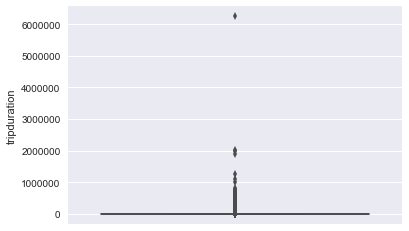

In [10]:
%%time
%matplotlib inline

#CitiBikeDataCompiledBackup = CitiBikeDataCompiled
#CitiBikeDataCompiled = CitiBikeDataCompiledBackup

    # BoxPlot tripDuration - Heavy Outliers!
sns.boxplot(y = "tripduration", data = CitiBikeDataCompiled)
sns.despine()
    
    # How Many Greater than 24 hours?
print(len(CitiBikeDataCompiled[CitiBikeDataCompiled["tripduration"]>86400]))

    # Remove > 24 Hours
CitiBikeDataCompiled = CitiBikeDataCompiled[CitiBikeDataCompiled["tripduration"]<86400]

Once outliers are removed, we run the boxplot again, still seeing skewness in results. To try to mitigate this left-skew distribution, we decide to take a log transform on this attribute. 

Wall time: 1.07 s


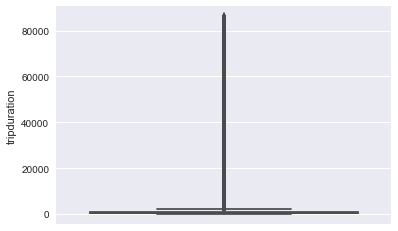

In [11]:
%%time
%matplotlib inline

    # BoxPlot Trip Duration AFTER removal of outliers
sns.boxplot(y = "tripduration", data = CitiBikeDataCompiled)
sns.despine()

    # Log Transform Column Added
CitiBikeDataCompiled["tripdurationLog"] = CitiBikeDataCompiled["tripduration"].apply(np.log)


Wall time: 1.06 s


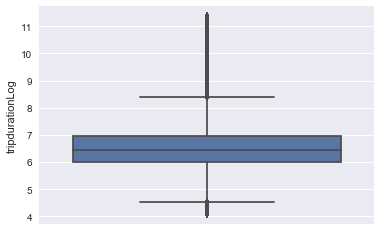

In [12]:
%%time
%matplotlib inline

    # BoxPlot TripDurationLog
sns.boxplot(y = "tripdurationLog", data = CitiBikeDataCompiled)
sns.despine()

**Age**

Similarly, we look at the distribution of Age in our dataset. Interestingly, it seems we have several outlier observations logging their birth year far enough back to cause their age to compute as 115 years old. Possible reasons for these outlier ages could be data entry errors by those who do not enjoy disclosing personal information, or possibly account sharing between a parent and a child - rendering an inaccurate data point to those actually taking the trip. Our target demographic for this study are those individuals under 65 years of age, given that they are the likely age groups to be in better physical condition for the bike share service. Given this target demographic, and the poor entries causing extreme outliers, we have chosen to limit out dataset to observations up to 65 years of age. This change removed an additional 53824 records from the dataset.

53824
Wall time: 4 s


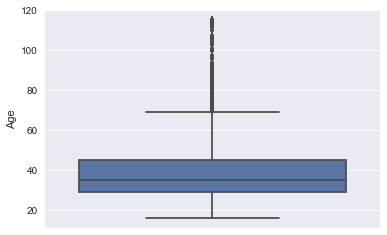

In [13]:
%%time
%matplotlib inline

    # BoxPlot Age - Outliers!
sns.boxplot(y = "Age", data = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]!= 0])
sns.despine()
    
    # How Many Greater than 65 years old?
print(len(CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]>65]))

    # Remove > 65 years old
CitiBikeDataCompiled = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]<=65]


Wall time: 1.93 s


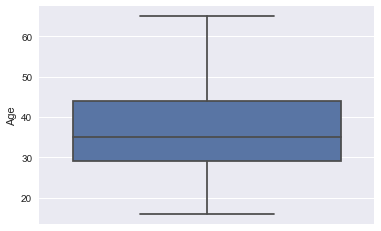

In [14]:
%%time
%matplotlib inline

    # BoxPlot Age - removed Outliers!
sns.boxplot(y = "Age", data = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]!= 0])
sns.despine()

###### Record Sampling to 500,000 Records
Given the extremely large volume of data collected, we have have decided to try to sample down to ~ 1/10th of the original dataset for a total of 500,000 records. Before taking this action, however, we wanted to ensure that we keep data proportions reasonable for analysis and ensure we do not lose any important demographic in our data.

Below we compute the percentage of our Dataset that comprises of Customers vs. Subscribers. We note, that 87.6% of the data consists of Subscriber users whereas the remaining 12.4% resemble Customers. 

,usertype,count
0,Customer,680796
1,Subscriber,4827216


Wall time: 565 ms


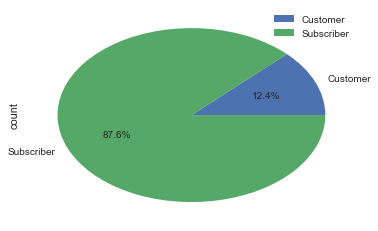

In [15]:
%%time
%matplotlib inline
UserTypeDist = pd.DataFrame({'count' : CitiBikeDataCompiled.groupby(["usertype"]).size()}).reset_index()
display(UserTypeDist)

UserTypeDist.plot.pie(y = 'count', labels = ['Customer', 'Subscriber'], autopct='%1.1f%%')

In our Sample Dataset for this analysis, we have chosen to oversample the Customer observations to force a 50/50 split between the two classifications. This will help reduce bias in the model towards Subscribers simply due to the distribution of data in the sample.

We are able to compute the sample size for each usertype and then take a random sample within each group. Below you will see that our sampled distribution matches the chosen 50/50 split between Customers and Subscriber Usertypes. 

500000


,usertype,count
0,Customer,250000
1,Subscriber,250000


Wall time: 4.89 s


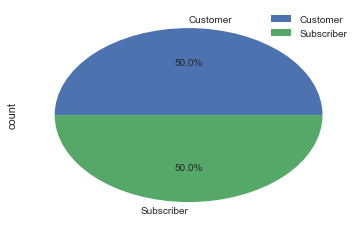

In [16]:
%%time
SampleSize = 500000

CustomerSampleSize_Seed   = int(round(SampleSize * 50.0 / 100.0,0))
SubscriberSampleSize_Seed = int(round(SampleSize * 50.0 / 100.0,0))

CitiBikeCustomerDataSampled = CitiBikeDataCompiled[CitiBikeDataCompiled["usertype"] == 'Customer'].sample(n=CustomerSampleSize_Seed, replace = False, random_state = CustomerSampleSize_Seed)
CitiBikeSubscriberDataSampled = CitiBikeDataCompiled[CitiBikeDataCompiled["usertype"] == 'Subscriber'].sample(n=SubscriberSampleSize_Seed, replace = False, random_state = SubscriberSampleSize_Seed)

CitiBikeDataSampled_5050 = pd.concat([CitiBikeCustomerDataSampled,CitiBikeSubscriberDataSampled])

print(len(CitiBikeDataSampled_5050))

UserTypeDist = pd.DataFrame({'count' : CitiBikeDataSampled_5050.groupby(["usertype"]).size()}).reset_index()
display(UserTypeDist)

UserTypeDist.plot.pie(y = 'count', labels = ['Customer', 'Subscriber'], autopct='%1.1f%%')



##### Prepping Data for Analysis

Now that we have the dataset sampled, we still have some legwork necessary to convert our categorical attributes into integer values. Below we walk through this process for the following Attributes:
- start_station_name
- end_station_name
- gender
- DayOfWeek
- TimeOfDay

Once these 5 attributes have been encoded using OneHotEncoding, we have added 79 attributes into our dataset for analysis in our model.

***Start Station Name***

Initially including all start (and end) locations resulted in excessive system resource loading, later during randomized principal component computations, that froze our personal workstations and eventually ended with Python 'MemoryError' messaging. Therefore, due to the extremely large quantity of start stations in our dataset (330 stations), we were required to reduce this dimension down to a manageable size manually. Through trial and error on top frequency stations, we have chosen to reduce this number down to ~ 10% its original number. By identifying the top 20 start stations for Subscribers / Customers separately, we found that there were 9 overlapping stations, producing a final list of 31 stations. While encoding our start_station_name integer columns, we limit the number of columns to these stations identified.

In [17]:

%%time
    
    #How many Start Stations are there?
print(len(CitiBikeDataSampled_5050["start_station_name"].drop_duplicates()))

    # Top 15 Start Station for Subscriber Users 
startstationsubfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Subscriber'].groupby(["start_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopSubStartStations = startstationsubfreq.head(20)

del startstationsubfreq

    # Top 15 Start Station for Customer Users 
startstationcustfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Customer'].groupby(["start_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopCustStartStations = startstationcustfreq.head(20)

del startstationcustfreq

    #Concat Subscribers and Customers
TopStartStations = pd.DataFrame(pd.concat([TopSubStartStations,TopCustStartStations])["start_station_name"].drop_duplicates()).reset_index()    
print(len(TopStartStations))
display(TopStartStations[["start_station_name"]])

del TopStartStations
del TopSubStartStations
del TopCustStartStations

    #Split Start Station Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.start_station_name,prefix='start_station_name')

CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit[["start_station_name_Pershing Square N", "start_station_name_E 17 St & Broadway", "start_station_name_8 Ave & W 31 St", "start_station_name_Lafayette St & E 8 St", "start_station_name_W 21 St & 6 Ave", "start_station_name_8 Ave & W 33 St", "start_station_name_W 20 St & 11 Ave", "start_station_name_Broadway & E 14 St", "start_station_name_Broadway & E 22 St", "start_station_name_W 41 St & 8 Ave", "start_station_name_Cleveland Pl & Spring St", "start_station_name_University Pl & E 14 St", "start_station_name_West St & Chambers St", "start_station_name_E 43 St & Vanderbilt Ave", "start_station_name_Broadway & W 24 St", "start_station_name_Greenwich Ave & 8 Ave", "start_station_name_W 18 St & 6 Ave", "start_station_name_Broadway & W 60 St", "start_station_name_Pershing Square S", "start_station_name_W 33 St & 7 Ave", "start_station_name_Central Park S & 6 Ave", "start_station_name_Centre St & Chambers St", "start_station_name_Grand Army Plaza & Central Park S", "start_station_name_Vesey Pl & River Terrace", "start_station_name_Broadway & W 58 St", "start_station_name_West Thames St", "start_station_name_12 Ave & W 40 St", "start_station_name_9 Ave & W 14 St", "start_station_name_W 14 St & The High Line", "start_station_name_State St", "start_station_name_Broadway & Battery Pl"]]),axis=1) # add back into the dataframe

del AttSplit

330
31


,start_station_name
0,Pershing Square N
1,E 17 St & Broadway
2,8 Ave & W 31 St
3,Lafayette St & E 8 St
4,W 21 St & 6 Ave
5,8 Ave & W 33 St
6,W 20 St & 11 Ave
7,Broadway & E 14 St
8,Broadway & E 22 St
9,W 41 St & 8 Ave


Wall time: 1.08 s


***End Station Name***

Similarly, we have an extremely large quantity of end stations in our dataset (330 stations) and including all of them resulted in system crashes during principal component analysis later in our lab. We were required to reduce this dimension down to a manageable size. Through trial and error on top frequency stations, we have chosen to reduce this number down to ~ 10% its original number. By identifying the top 20 end stations for Subscribers / Customers separately, we found that there were 7 overlapping stations, producing a final list of 33 stations. While encoding our end_station_name integer columns, we limit the number of columns to these stations identified.

In [18]:
%%time
    
    #How many End Stations are there?
print(len(CitiBikeDataSampled_5050["end_station_name"].drop_duplicates()))

    # Top 15 Start Station for Subscriber Users 
endstationsubfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Subscriber'].groupby(["end_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopSubendStations = endstationsubfreq.head(20)

del endstationsubfreq

    # Top 15 Start Station for Customer Users 
endstationcustfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Customer'].groupby(["end_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopCustendStations = endstationcustfreq.head(20)

del endstationcustfreq

    #Concat Subscribers and Customers
TopendStations = pd.DataFrame(pd.concat([TopSubendStations,TopCustendStations])["end_station_name"].drop_duplicates()).reset_index()    
print(len(TopendStations))
display(TopendStations[["end_station_name"]])

del TopendStations
del TopSubendStations
del TopCustendStations

    #Split Start Station Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.end_station_name,prefix='end_station_name')

CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit[["end_station_name_E 17 St & Broadway", "end_station_name_Lafayette St & E 8 St", "end_station_name_8 Ave & W 31 St", "end_station_name_W 21 St & 6 Ave", "end_station_name_Pershing Square N", "end_station_name_W 20 St & 11 Ave", "end_station_name_Broadway & E 14 St", "end_station_name_Broadway & E 22 St", "end_station_name_University Pl & E 14 St", "end_station_name_W 41 St & 8 Ave", "end_station_name_West St & Chambers St", "end_station_name_Cleveland Pl & Spring St", "end_station_name_Greenwich Ave & 8 Ave", "end_station_name_E 43 St & Vanderbilt Ave", "end_station_name_Broadway & W 24 St", "end_station_name_W 18 St & 6 Ave", "end_station_name_MacDougal St & Prince St", "end_station_name_Carmine St & 6 Ave", "end_station_name_8 Ave & W 33 St", "end_station_name_2 Ave & E 31 St", "end_station_name_Central Park S & 6 Ave", "end_station_name_Centre St & Chambers St", "end_station_name_Grand Army Plaza & Central Park S", "end_station_name_Broadway & W 60 St", "end_station_name_Broadway & W 58 St", "end_station_name_12 Ave & W 40 St", "end_station_name_Vesey Pl & River Terrace", "end_station_name_W 14 St & The High Line", "end_station_name_9 Ave & W 14 St", "end_station_name_West Thames St", "end_station_name_State St", "end_station_name_Old Fulton St", "end_station_name_South End Ave & Liberty St"]]),axis=1) # add back into the dataframe

del AttSplit

330
33


,end_station_name
0,E 17 St & Broadway
1,Lafayette St & E 8 St
2,8 Ave & W 31 St
3,W 21 St & 6 Ave
4,Pershing Square N
5,W 20 St & 11 Ave
6,Broadway & E 14 St
7,Broadway & E 22 St
8,University Pl & E 14 St
9,W 41 St & 8 Ave


Wall time: 1.37 s


**Gender, DayOfWeek, and TimeOfDay**

The rest of our encoding attributes {Gender, DayOfWeek, and TimeOfDay} have the following value permutations. These permutations will be encoded as individual integer columns as well.

- Gender:    {0 = unknown, 1 = male, 2 = female}
- DayOfWeek: {Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday}
- TimeOfDay: {Morning, Midday, Afternoon, Evening, Night}

In [19]:
%%time

    #Split gender Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.gender,prefix='gender')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

    #Split DayOfWeek Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.DayOfWeek,prefix='DayOfWeek')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

    #Split TimeOfDay Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.TimeOfDay,prefix='TimeOfDay')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

display(CitiBikeDataSampled_5050.head())


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth year,gender,LinearDistance,DayOfWeek,TimeOfDay,HolidayFlag,PRCP,SNOW,TAVE,TMAX,TMIN,Age,tripdurationLog,start_station_name_Pershing Square N,start_station_name_E 17 St & Broadway,start_station_name_8 Ave & W 31 St,start_station_name_Lafayette St & E 8 St,start_station_name_W 21 St & 6 Ave,start_station_name_8 Ave & W 33 St,start_station_name_W 20 St & 11 Ave,start_station_name_Broadway & E 14 St,start_station_name_Broadway & E 22 St,start_station_name_W 41 St & 8 Ave,start_station_name_Cleveland Pl & Spring St,start_station_name_University Pl & E 14 St,start_station_name_West St & Chambers St,start_station_name_E 43 St & Vanderbilt Ave,start_station_name_Broadway & W 24 St,start_station_name_Greenwich Ave & 8 Ave,start_station_name_W 18 St & 6 Ave,start_station_name_Broadway & W 60 St,start_station_name_Pershing Square S,start_station_name_W 33 St & 7 Ave,start_station_name_Central Park S & 6 Ave,start_station_name_Centre St & Chambers St,start_station_name_Grand Army Plaza & Central Park S,start_station_name_Vesey Pl & River Terrace,start_station_name_Broadway & W 58 St,start_station_name_West Thames St,start_station_name_12 Ave & W 40 St,start_station_name_9 Ave & W 14 St,start_station_name_W 14 St & The High Line,start_station_name_State St,start_station_name_Broadway & Battery Pl,end_station_name_E 17 St & Broadway,end_station_name_Lafayette St & E 8 St,end_station_name_8 Ave & W 31 St,end_station_name_W 21 St & 6 Ave,end_station_name_Pershing Square N,end_station_name_W 20 St & 11 Ave,end_station_name_Broadway & E 14 St,end_station_name_Broadway & E 22 St,end_station_name_University Pl & E 14 St,end_station_name_W 41 St & 8 Ave,end_station_name_West St & Chambers St,end_station_name_Cleveland Pl & Spring St,end_station_name_Greenwich Ave & 8 Ave,end_station_name_E 43 St & Vanderbilt Ave,end_station_name_Broadway & W 24 St,end_station_name_W 18 St & 6 Ave,end_station_name_MacDougal St & Prince St,end_station_name_Carmine St & 6 Ave,end_station_name_8 Ave & W 33 St,end_station_name_2 Ave & E 31 St,end_station_name_Central Park S & 6 Ave,end_station_name_Centre St & Chambers St,end_station_name_Grand Army Plaza & Central Park S,end_station_name_Broadway & W 60 St,end_station_name_Broadway & W 58 St,end_station_name_12 Ave & W 40 St,end_station_name_Vesey Pl & River Terrace,end_station_name_W 14 St & The High Line,end_station_name_9 Ave & W 14 St,end_station_name_West Thames St,end_station_name_State St,end_station_name_Old Fulton St,end_station_name_South End Ave & Liberty St,gender_0,gender_1,gender_2,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Midday,TimeOfDay_Morning,TimeOfDay_Night
178325,2023,2013-07-07 14:25:39,2013-07-07 14:59:22,245,Myrtle Ave & St Edwards St,40.693270,-73.977039,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,17767,Customer,0,0,1.760372,Sunday,Afternoon,0,0.00,0.0,85,92,78,0,7.612337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
112533,383,2013-10-09 20:27:55,2013-10-09 20:34:18,334,W 20 St & 7 Ave,40.742388,-73.997262,509,9 Ave & W 22 St,40.745497,-74.001971,18523,Customer,0,0,0.327278,Wednesday,Evening,0,0.00,0.0,58,62,53,0,5.948035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
199683,634,2013-09-01 17:40:41,2013-09-01 17:51:15,363,West Thames St,40.708347,-74.017134,3002,South End Ave & Liberty St,40.711512,-74.015756,20173,Customer,0,0,0.230075,Sunday,Evening,0,0.00,0.0,80,84,75,0,6.452049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Wall time: 2.18 s


With these encodings complete, our final dataset to cross-validate on test/train datasets would appear to be complete. However, given the large number of attributes now present in our dataset, it would be wise to investigate a means of dimensionality reduction to not only speed up model generation, but to also improve accuracy by removing variable redundancy and correlation.

## Data Preparation Part 2 - Describe the final dataset that is used for classification/regression

##### Dimensionality Reduction using Principal Component Analysis

With our data split evenly among customer and subscriber user types and OneHotEncoding complete, we are ready to consider the new dimensions of our dataset. Because our processed data is comprised of 105 various attributes ranging from weather and distance data to location and user type data across all 500,000 sample observations, and some variables such as weather attributes and even some start and end stations correlate to one another as depicted in the correlation matrix below, we feel it would be wise to reduce our number of attributes considered during model generation. After considering a variety of feature selection techniques, we've opted for dimensionality reduction via principal component analysis (PCA).

(500000, 105)
Wall time: 39.1 s


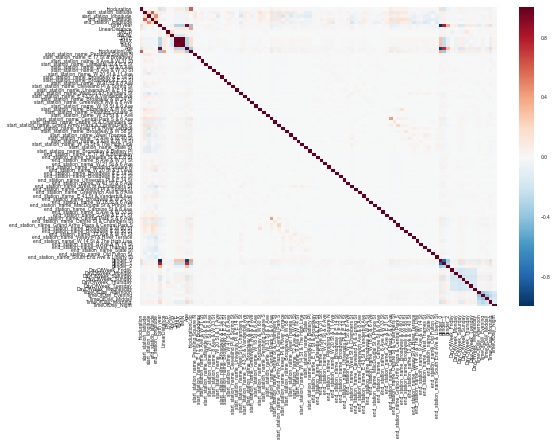

In [20]:
%%time

print(CitiBikeDataSampled_5050.shape)

sns.set(font_scale=0.5)
sns.heatmap(CitiBikeDataSampled_5050.corr(), 
            xticklabels=CitiBikeDataSampled_5050.corr().columns.values,
            yticklabels=CitiBikeDataSampled_5050.corr().columns.values)


By performing PCA, we are able to shrink the number of variables required for prediction purposes, replacing our latest variables derived up to this point with linear combinations of themselves. Each of these linear combinations makes up a component and comprises an eigenvector. When these eigenvectors are ordered by largest eigenvalues, representing the extent of variability explained by each vector, the vectors with largest eigenvalues may be identified as the principal components of the analysis. Selecting only those components which describe the most variance will help us reduce processing times and improve model performance and accuracy by avoiding variable inflation and overfitting associated with high dimensionality.

Since this lab consists of two primary tasks (the first being to classify user types and the second being to predict trip duration), this section outlines two different PCA's, one for each task, in order to identify the appropriate number of components to include during model generation in subsequent sections. The appropriate number of components must be derived separately since user type classification will include trip duration predictors whereas trip duration prediction will require user type predictors. The expectation is that the number of components should be similar for both tasks, but it is not enough to make this assumption alone; both will be reviewed independently.

##### PCA for Classification
Our first objective is to identify the number of components to be used for user type classification. In order to do so, we first exclude redundant and non-value variables up front. Non-value variables include gender, birth year, and age since these data were missing for most Customer user types and were replaced with filler values as discussed in previous sections. We will exclude these since they misrepresent correlation with user type. Remaining attribute data will then be standardized so that all variables are on the same scale given that our explanatory variables are comprised of many different measures.

*(Note: PCA code steps adapted and modified from https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/)*

In [21]:
%%time

class_att = CitiBikeDataSampled_5050.drop(['starttime', 'stoptime', 'start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'usertype', 'gender', 'gender_0', 'gender_1', 'gender_2', 'birth year', 'Age', 'tripduration', 'DayOfWeek', 'TimeOfDay'], axis=1)
myData = class_att.as_matrix() 

min_max_scaler = MinMaxScaler()
myData_scaled_classification = min_max_scaler.fit_transform(myData)

del myData

D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Wall time: 5.99 s


After excluding duplicate and non-value attributes and scaling our data, we verify that 89 attributes remain. The maximum number of components to be produced will match this number. For this reason, we will identify 89 to be the number of components produced by our PCA and will review each component's explained variance further to determine the proper number of components to be included later during model generation. Note randomized PCA was chosen in order to use singular value decomposition in our dimensionality reduction efforts due to the large size of our data set. Using full PCA required unacceptable lengths of time to compute.

In [22]:
%%time
print(myData_scaled_classification.shape)
pca_class = PCA(n_components=89, svd_solver='randomized')

pca_class.fit(myData_scaled_classification)

(500000, 89)
Wall time: 13.3 s


Below, the resulting components have been ordered by eigenvector value and these values portrayed as ratios of variance explained by each component. In order to identify the principal components to be included during model generation, we review the rate at which explained variance decreases in significance from one principal component to the next. Accompanying these proportion values is a scree plot representing these same values in visual form. By plotting the scree plot, it is easier to judge where this rate of decreasing explained variance occurs. Note the rate of change in explained variance among the first 14 principal components – the change is rather steep through the 14th component. After the 1% drop between components 14 and 15, the rate of decreasing explained variance begins to somewhat flatten out, reducing to a 0.2% change or less.

[ 11.72   9.14   7.75   6.86   5.53   5.35   5.23   5.15   5.09   4.42
   3.74   3.46   2.47   2.01   1.07   1.01   0.86   0.66   0.63   0.49
   0.47   0.44   0.41   0.4    0.39   0.38   0.38   0.37   0.36   0.35
   0.34   0.34   0.33   0.33   0.33   0.32   0.32   0.32   0.32   0.31
   0.31   0.3    0.3    0.29   0.29   0.28   0.27   0.27   0.26   0.26
   0.26   0.26   0.25   0.25   0.25   0.25   0.25   0.24   0.24   0.24
   0.24   0.23   0.23   0.23   0.22   0.22   0.22   0.21   0.21   0.21
   0.2    0.2    0.2    0.19   0.19   0.19   0.18   0.18   0.18   0.18
   0.17   0.17   0.15   0.15   0.05   0.04   0.     0.     0.  ]


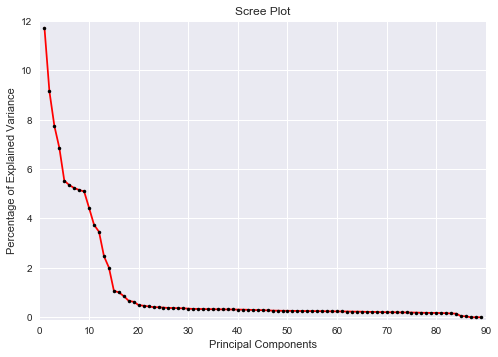

In [23]:
#The amount of variance that each PC explains
var= pca_class.explained_variance_ratio_

sns.set(font_scale=1)
plt.plot(range(1,90), var*100, marker = '.', color = 'red', markerfacecolor = 'black')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained Variance')
plt.title('Scree Plot')
plt.axis([0, 90, -0.1, 12])

np.set_printoptions(suppress=True)
print(np.round(var, decimals=4)*100)

By now referring to the cumulative variance values and associated plot below, it may be seen that the cumulative variance arguably begins to plateau around the 14th principal component and that the first 14 components together explain 77.92% of variance in the data set. For this reason, 14 principal components may be selected as being the most appropriate for user type classification modeling given the variables among these data.

[  11.72   20.86   28.61   35.47   41.     46.35   51.58   56.73   61.82
   66.24   69.98   73.44   75.91   77.92   78.99   80.     80.86   81.52
   82.15   82.64   83.11   83.55   83.96   84.36   84.75   85.13   85.51
   85.88   86.24   86.59   86.93   87.27   87.6    87.93   88.26   88.58
   88.9    89.22   89.54   89.85   90.16   90.46   90.76   91.05   91.34
   91.62   91.89   92.16   92.42   92.68   92.94   93.2    93.45   93.7
   93.95   94.2    94.45   94.69   94.93   95.17   95.41   95.64   95.87
   96.1    96.32   96.54   96.76   96.97   97.18   97.39   97.59   97.79
   97.99   98.18   98.37   98.56   98.74   98.92   99.1    99.28   99.45
   99.62   99.77   99.92   99.97  100.01  100.01  100.01  100.01]


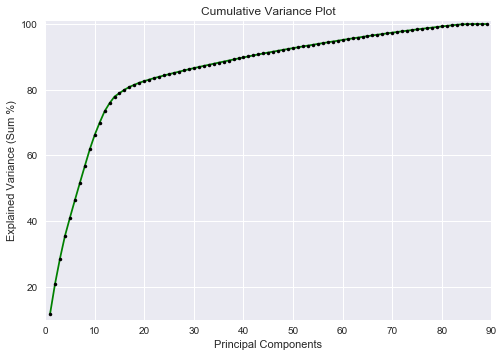

In [24]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca_class.explained_variance_ratio_, decimals=4)*100)

plt.plot(range(1,90), var1, marker = '.', color = 'green', markerfacecolor = 'black')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance (Sum %)')
plt.title('Cumulative Variance Plot')
plt.axis([0, 90, 10, 101])

print(var1)

In [25]:
%time pca_classification = PCA(n_components=14, svd_solver='randomized')

Wall time: 0 ns


##### PCA for Regression

Now that 14 principal components have been identified for Customer/Subscriber classification, we want to determine the correct number of principal components to use when predicting trip duration. For regression, we will need to interchange user type and log trip duration (which will be what we are actually predicting later before back transforming to regular trip duration) inclusion/exclusion. Before including user type, however, OneHotEncoding this variable is required since this has not been done as user type has always been discussed in terms of response up to this point (classification).

We will also be removing end station names for regression since, contextually, CitiBike does not know the end location of a rider at the time the rider checks out a bike. Yes, this information becomes available at checkin... but if the company is to counterbalance the shortage effects of having too many bikes checked out during the same period of time, the model needs to exclude trip end location details. This concept will be discussed further later in this writeup. Again, all attributes are standardized before eigenvectors are computed for reasons stated previously.

In [26]:
%%time

# Generate usertype dummies for use in regression PCA
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.usertype,prefix='usertype')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

# Include usertype but exclude trip duration
reg_att = CitiBikeDataSampled_5050.drop(['starttime', 'stoptime', 'start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'usertype','tripdurationLog', 'gender', 'gender_0', 'gender_1', 'gender_2', 'birth year', 'Age', 'tripduration', 'DayOfWeek', 'TimeOfDay', 'LinearDistance'], axis=1)
myData = reg_att.columns.values.tolist() 
myData = [i for i in myData if "end_station_name_" not in i]
reg_att = CitiBikeDataSampled_5050[myData]

min_max_scaler = MinMaxScaler()
myData_scaled_regression = min_max_scaler.fit_transform(reg_att.as_matrix())

del myData

D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


Wall time: 4.65 s


After OneHotEncoding the user type variable, including only appropriate variables, and standardizing, we are left with 56 attributes. Therefore we can expect to produce a total of 56 linear combinations in all.

In [27]:
%%time

print(myData_scaled_regression.shape)
pca_reg = PCA(n_components=56, svd_solver='randomized')

pca_reg.fit(myData_scaled_regression)

(500000, 56)
Wall time: 7.41 s


Ordering the resulting eigenvectors by variance proportion explained and plotting the scree plot below reveals dramatic change in explained variance through component 15. The 0.85% change in explained variance between components 15 and 16 flattens out to changes less than 0.33% between components thereafter.

[ 19.91  10.51   8.35   6.4    5.94   5.05   4.87   4.78   4.7    4.61
   3.68   3.34   3.15   2.26   1.8    0.95   0.91   0.58   0.39   0.38
   0.36   0.33   0.33   0.33   0.32   0.31   0.3    0.3    0.3    0.29
   0.28   0.28   0.27   0.25   0.23   0.23   0.23   0.22   0.22   0.22
   0.21   0.2    0.19   0.18   0.17   0.17   0.16   0.16   0.15   0.14
   0.04   0.03   0.     0.     0.     0.  ]


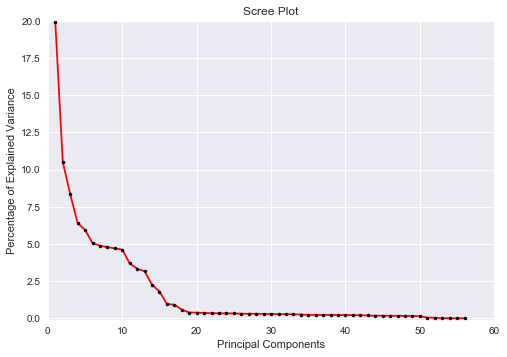

In [28]:
#The amount of variance that each PC explains
var= pca_reg.explained_variance_ratio_

plt.plot(range(1,57), var*100, marker = '.', color = 'red', markerfacecolor = 'black')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained Variance')
plt.title('Scree Plot')
plt.axis([0, 60, -0.1, 20])

np.set_printoptions(suppress=True)
print(np.round(var, decimals=4)*100)

The cumulative variance values and plot that follow indicate that total variance begins to plateau around the 15th principal component, supporting our previous conclusions. The plot also indicates the first 15 components explain 89.35% of data set variance. Based on these results, we will use 15 principal components for our trip duration prediction models.

[ 19.91  30.42  38.77  45.17  51.11  56.16  61.03  65.81  70.51  75.12
  78.8   82.14  85.29  87.55  89.35  90.3   91.21  91.79  92.18  92.56
  92.92  93.25  93.58  93.91  94.23  94.54  94.84  95.14  95.44  95.73
  96.01  96.29  96.56  96.81  97.04  97.27  97.5   97.72  97.94  98.16
  98.37  98.57  98.76  98.94  99.11  99.28  99.44  99.6   99.75  99.89
  99.93  99.96  99.96  99.96  99.96  99.96]


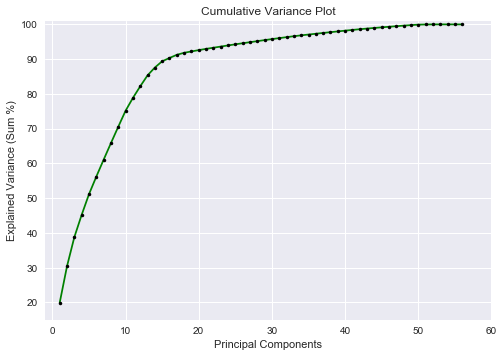

In [29]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca_reg.explained_variance_ratio_, decimals=4)*100)

plt.plot(range(1,57), var1, marker = '.', color = 'green', markerfacecolor = 'black')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance (Sum %)')
plt.title('Cumulative Variance Plot')
plt.axis([-1, 60, 15, 101])

print(var1)

In [30]:
%time pca_regression = PCA(n_components=15, svd_solver='randomized')

Wall time: 0 ns


##### Data Set Summary

At this stage, we've converted our original 30 variables into 107 attributes after creating dummy variables for categorical data such as day of the week, time of day, station names, gender, etc. These 107 attributes and their data types are as follows:

In [31]:
%%time

data_type = []
for idx, col in enumerate(CitiBikeDataSampled_5050.columns):
    data_type.append(CitiBikeDataSampled_5050.dtypes[idx])

summary_df = {'Attribute Name' : pd.Series(CitiBikeDataSampled_5050.columns, index = range(len(CitiBikeDataSampled_5050.columns))), 'Data Type' : pd.Series(data_type, index = range(len(CitiBikeDataSampled_5050.columns)))}
summary_df = pd.DataFrame(summary_df)
display(summary_df)

del data_type, summary_df

,Attribute Name,Data Type
0,tripduration,int64
1,starttime,datetime64[ns]
2,stoptime,datetime64[ns]
3,start_station_id,object
4,start_station_name,object
5,start_station_latitude,float64
6,start_station_longitude,float64
7,end_station_id,object
8,end_station_name,object
9,end_station_latitude,float64


Wall time: 38.5 ms


Even with our data cleaned and prepped using OneHotEncoding, there is the innate need to reduce this number of attributes to a more manageable size before classification and regression predictions are made. For this reason, we've performed randomized PCA to compute linear combinations of the data and have chosen to use the first 14 principal components for the *n_components* parameter in our classification PCA and the first 15 principal components for regression PCA, based on explained variance and cumulative variance measures.

Eigenvectors, proportions of explained variance, and cumulative proportions of explained variance are provided for the classification principal components and then again for regression principal components below.

In [32]:
%%time

# Classification Task Principal Component Breakdown
pca_classification.fit(myData_scaled_classification)
var = pca_classification.explained_variance_
var1 = pca_classification.explained_variance_ratio_
var2 = np.cumsum(np.round(pca_classification.explained_variance_ratio_, decimals=4))
idx = ['PC'+str(i) for i in range(1,15)]

PCA_df = {'...Eigenvector...' : pd.Series(var, index = idx),
          '..Variance Proportion..' : pd.Series(var1, index = idx),
          '.Variance Cumulative Proportion.' : pd.Series(var2, index = idx)}

PCA_df = pd.DataFrame(PCA_df)
print('Classification Task Principal Component Breakdown')
display(PCA_df)

del var, var1, var2, idx
pca_classification = PCA(n_components=14, svd_solver='randomized')

Classification Task Principal Component Breakdown


,...Eigenvector...,..Variance Proportion..,.Variance Cumulative Proportion.
PC1,0.292249,0.117202,0.1172
PC2,0.227935,0.091410,0.2086
PC3,0.193138,0.077455,0.2861
PC4,0.170967,0.068564,0.3547
PC5,0.137889,0.055298,0.4100
PC6,0.133436,0.053513,0.4635
PC7,0.130424,0.052305,0.5158
PC8,0.128513,0.051538,0.5673
PC9,0.126957,0.050914,0.6182
PC10,0.110321,0.044243,0.6624


Wall time: 3.85 s


In [33]:
%%time

# Regression Task Principal Component Breakdown
pca_regression.fit(myData_scaled_regression)
var = pca_regression.explained_variance_
var1 = pca_regression.explained_variance_ratio_
var2 = np.cumsum(np.round(pca_regression.explained_variance_ratio_, decimals=4))
idx = ['PC'+str(i) for i in range(1,16)]

PCA_df = {'...Eigenvector...' : pd.Series(var, index = idx),
          '..Variance Proportion..' : pd.Series(var1, index = idx),
          '.Variance Cumulative Proportion.' : pd.Series(var2, index = idx)}

PCA_df = pd.DataFrame(PCA_df)
print('Regression Task Principal Component Breakdown')
display(PCA_df)

del var, var1, var2, idx
pca_regression = PCA(n_components=15, svd_solver='randomized')

Regression Task Principal Component Breakdown


,...Eigenvector...,..Variance Proportion..,.Variance Cumulative Proportion.
PC1,0.543599,0.199150,0.1991
PC2,0.286795,0.105069,0.3042
PC3,0.227803,0.083456,0.3877
PC4,0.174663,0.063988,0.4517
PC5,0.162081,0.059379,0.5111
PC6,0.137883,0.050514,0.5616
PC7,0.133068,0.048750,0.6103
PC8,0.130423,0.047781,0.6581
PC9,0.128329,0.047014,0.7051
PC10,0.125964,0.046147,0.7512


Wall time: 3.54 s


While our discussions revolving data preparation and principal component derivations address our current interests for variable understanding moving forward into modeling and evaluation, there is still more to be understood regarding principal component loadings. Loadings will be described as we discuss the most important attributes for our tasks later in the Modeling and Evaluation 6 section.

## Modeling and Evaluation Part 1 - Choose and explain the evaluation metrics that will be used

### Michael for Eval Metrics
*XXXXXX (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions. XXXXXX*

## Modeling and Evaluation Part 2 - Build Test & Train Datasets

#### Classification
With our final encoded dataset complete, and PCA analysis performed to identify our principal components we begin splitting the data into Test vs Train datasets. We have chosen to utilize Stratified KFold Cross Validation for our classification analysis, with 10 folds. This means, that from our original sample size of 500,000, each "fold" will save off approximately 10% as test observations utilizing the rest as training observations all while keeping the ratio of classes equal amongst customers and subscribers. This process will occur through 10 iterations, or folds, to allow us to cross validate our results amongst different test/train combinations. We have utilized a random_state seed equal to the length of the original sampled dataset to ensure reproducible results.  

In [34]:
    # Create CV Object for StratifiedKFold with 10 Folds, seeded at the length of our sample size
seed = len(CitiBikeDataSampled_5050)

cv = StratifiedKFold(n_splits = 10, random_state = seed)
print(cv)

StratifiedKFold(n_splits=10, random_state=500000, shuffle=False)


#### Regression
Alternatively, we have chosen to utilize standard KFold Cross Validation for our regresssion analysis, with 10 folds. This is because our regression target is a continuous attribute, and we have already done stratification of the original dataset in general. We have chosen to shuffle the data before splitting into batches to prevent any potential issues with the order of our dataset. Once again, this means, that from our original sample size of 500,000, data will be randomly shuffled then each "fold" will save off approximately 10% as test observations utilizing the rest as training observations. This process will occur through 10 iterations, or folds, to allow us to cross validate our results amongst different test/train combinations. We continue to utilize the previously established random_state seed equal to the length of the original sampled dataset to ensure reproducible results.  

In [35]:
    # Create CV Object for KFold with 10 Folds, seeded at the length of our sample size

cvReg = KFold(n_splits = 10, shuffle = True, random_state = seed)
print(cvReg)

KFold(n_splits=10, random_state=500000, shuffle=True)


## Modeling and Evaluation Part 3 - Build/Tune Three Classification Models (usertype predictions)
Now that our classification train/test cross-validation splits are configured, it is time to generate our classifiers. We have chosen to utilize the following three classification methods for our Subscriber/Customer prediction task:

1. Logistic Regression
2. Random Forest
3. K Nearest Neighbors (KNN)

We chose to create a logistic regression model it performed better than SVM during our previous mini-lab. Random Forest was also selected because we expected it to produce the most accurate model among all three of our classifiers. Finally, KNN was selected as our third classifier type since it functions rather differently from the logistic regression and random forest in that it computes distance between records, identifying k nearest neighbors and using the class labels of nearest neighbors to identify unknown record labels. All three classification methods take very different approaches to the same task and should make for some interesting comparisons.

*It is important to note that while we have left our function definitions uncommented for each model type, we have commented out the actual model generation code blocks due to their long run-times. Alternatively, we ran the code before commenting and then embedded the rendered HTML outputs in the cell block following the code for interpretation. This allows us to provide the model code outputs while significantly reducing project development times.*

#### Logistic Regression

Our first classifier model built is the logistic regression model. As we would like to test the effects of parameter adjustment on model accuracies for each classification method, we have primarily one parameter in our logistic regression fit that appears appropriate to manipulate for accuracies. We have chosen to manipulate the cost variable (*C*) within our logistic regression analyzing accuracies at {1.0, .01, .05, 5}. This parameter is essentially an inverted regularization strength equal to 1/lambda per scikit-learn class function code (lambda being the actual regularization item). Therefore, the smaller the cost value the stronger the regularization. Calculations show that our best value for cost = 0.01 (mean accuracy across 10 iterations = 0.681886), and that accuracy values were very close and even shifted order between most to least accurate from iteration to iteration. While it may not intuitively make sense up front that the strongest regularization value is best given that a cost value of 1 was best during our mini-lab, it is important to remember that we are now using principal components in our model; the mini-lab used the original, unscaled, CitiBike attributes. Though the change in accuracy is minimal, and maybe even negligible, it appears our principal components inputs benefit slightly from added regularization.

In [36]:
%%time

def lr_explor(cost,  
              ScaledData,
              PCA         = pca_classification,
              Data        = CitiBikeDataSampled_5050,
              cv          = cv,
              seed        = seed):
    
    startTime = datetime.now()
    y = Data['usertype'].values # get the labels we want
    y = np.where(y == 'Subscriber', 1, 0)    
    
    X = ScaledData
    
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None, random_state=seed) # get object
    
    # setup pipeline to take PCA, then fit a clf model
    clf_pipe = Pipeline(
        [('PCA',PCA),
         ('CLF',lr_clf)]
    )

    accuracy = cross_val_score(clf_pipe, X, y, cv=cv.split(X, y)) # this also can help with parallelism
    MeanAccuracy =  sum(accuracy)/len(accuracy)
    accuracy = np.append(accuracy, MeanAccuracy)
    endTime = datetime.now()
    TotalTime = endTime - startTime
    accuracy = np.append(accuracy, TotalTime)
    return accuracy



Wall time: 0 ns


In [37]:
## The Below Code is commented out due to its long run-time. 
##The Rendered HTML Table output has been hardcoded in the next cell block for interpretations 

#%%time
#
#acclist = [] 
#
#cost    = [.01, .05, 1.0, 5.0]
#
#
#for i in range(0,len(cost)):
#    acclist.append(lr_explor(cost       = cost[i],
#                             ScaledData = myData_scaled_classification))
#
#LRcostdf = pd.DataFrame(pd.concat([pd.DataFrame(cost),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#LRcostdf.columns = ['Cost','Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanAccuracy', 'RunTime']
#display(LRcostdf)

<div class="output_subarea output_html rendered_html"><div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Cost</th>
      <th>Iteration 0</th>
      <th>Iteration 1</th>
      <th>Iteration 2</th>
      <th>Iteration 3</th>
      <th>Iteration 4</th>
      <th>Iteration 5</th>
      <th>Iteration 6</th>
      <th>Iteration 7</th>
      <th>Iteration 8</th>
      <th>Iteration 9</th>
      <th>MeanAccuracy</th>
      <th>RunTime</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.01</td>
      <td>0.68128</td>
      <td>0.68198</td>
      <td>0.68054</td>
      <td>0.68190</td>
      <td>0.68584</td>
      <td>0.67858</td>
      <td>0.68522</td>
      <td>0.67878</td>
      <td>0.68100</td>
      <td>0.68374</td>
      <td>0.681886</td>
      <td>00:00:55.301026</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.05</td>
      <td>0.68122</td>
      <td>0.68212</td>
      <td>0.68052</td>
      <td>0.68208</td>
      <td>0.68588</td>
      <td>0.67842</td>
      <td>0.68508</td>
      <td>0.67870</td>
      <td>0.68080</td>
      <td>0.68372</td>
      <td>0.681854</td>
      <td>00:00:54.031372</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1.00</td>
      <td>0.68136</td>
      <td>0.68208</td>
      <td>0.68050</td>
      <td>0.68208</td>
      <td>0.68586</td>
      <td>0.67848</td>
      <td>0.68504</td>
      <td>0.67882</td>
      <td>0.68080</td>
      <td>0.68374</td>
      <td>0.681876</td>
      <td>00:00:53.148202</td>
    </tr>
    <tr>
      <th>3</th>
      <td>5.00</td>
      <td>0.68138</td>
      <td>0.68202</td>
      <td>0.68048</td>
      <td>0.68210</td>
      <td>0.68586</td>
      <td>0.67846</td>
      <td>0.68508</td>
      <td>0.67876</td>
      <td>0.68082</td>
      <td>0.68376</td>
      <td>0.681872</td>
      <td>00:00:52.870310</td>
    </tr>
  </tbody>
</table>
</div></div>

#### Random Forest Classification

**Max Depth**
The maximum depth (levels) in the tree. When a value is set, the tree may not split further once this level has been met regardless of how many nodes are in the leaf. 

**Max Features**
Number of features to consider when looking for a split. 

**Minimum Samples in Leaf**
Minimum number of samples required to be in a leaf node. Splits may not occur which cause the number of samples in a leaf to be less than this value. Too low a value here leads to overfitting the tree to train data.

**Minimum Samples to Split**
Minimum number fo samples required to split a node. Care was taken during parameter tests to keep the ratio between Min Samples in Leaf and Min Samples to Split equal to that of the default values (1:2). This was done to allow an even 50/50 split on nodes which match the lowest granularity split criteria. similar to the min samples in leaf, too low a value here leads to overfitting the tree to train data.

**n_estimators**
Number of Trees generated in the forest. Increasing the number of trees, in our models increased accuracy while decreasing performance. We tuned to provide output that completed all 10 iterations in under 10 minutes.

After 13 iterations of modifying the above parameters, we land on a final winner based on the highest average Accuracy value across all iterations. Average Accuracy values in our 10 test/train iterations ranged from 70.2668 % from default inputs of the random forest classification model to a value of 72.5192 % in the best tuned model fit. Although the run-time of this model parameter choice is the largest performed, we decided to remain with these inputs due to the amount increase in accuracy. As mentioned previously, we tuned the n_estimators parameter to ensure we stayed under 10 minutes execution. Parameter inputs for the final Random Forest Classification model with the KD Tree Algorithm are as follows:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>max_depth</th>
      <th>max_features</th>
      <th>min_samples_leaf</th>
      <th>min_samples_split</th>
      <th>n_estimators</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1000.0</th>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>15</td>
    </tr>
  </tbody>
</table>


In [38]:
%%time


def rfc_explor(ScaledData,
               n_estimators,
               max_features,
               max_depth, 
               min_samples_split,
               min_samples_leaf, 
               PCA         = pca_classification,
               Data        = CitiBikeDataSampled_5050,
               cv          = cv,
               seed        = seed):
    startTime = datetime.now()
    y = Data['usertype'].values # get the labels we want
    y = np.where(y == 'Subscriber', 1, 0)    
    
    X = ScaledData
    
    rfc_clf = RandomForestClassifier(n_estimators=n_estimators, max_features = max_features, max_depth=max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, n_jobs=-1, random_state = seed) # get object
    
    # setup pipeline to take PCA, then fit a clf model
    clf_pipe = Pipeline(
        [('PCA',PCA),
         ('CLF',rfc_clf)]
    )

    accuracy = cross_val_score(clf_pipe, X, y, cv=cv.split(X, y)) # this also can help with parallelism
    MeanAccuracy =  sum(accuracy)/len(accuracy)
    accuracy = np.append(accuracy, MeanAccuracy)
    endTime = datetime.now()
    TotalTime = endTime - startTime
    accuracy = np.append(accuracy, TotalTime)
    
    #print(TotalTime)
    #print(accuracy)
    
    return accuracy


Wall time: 0 ns


In [39]:

## The Below Code is commented out due to its long run-time. 
##The Rendered HTML Table output has been hardcoded in the next cell block for interpretations 


#%%time
#
#acclist = [] 
#
#n_estimators       =  [10    , 10     , 10    , 10    , 10    , 10    , 10    , 10    , 10    , 10    , 10  , 5    , 15   ]  
#max_features       =  ['auto', 'auto' , 'auto', 'auto', 'auto', 'auto', 'auto', 14    , 14    , 14    , 14  , 14   , 14   ] 
#max_depth          =  [None  , None   , None  , None  , None  , None  , None  , None  , 1000  , 500   , 100 , 1000 , 1000 ] 
#min_samples_split  =  [2     , 8      , 12    , 16    , 20    , 50    , 80    , 50    , 50    , 50    , 50  , 50   , 50   ] 
#min_samples_leaf   =  [1     , 4      , 6     , 8     , 10    , 25    , 40    , 25    , 25    , 25    , 25  , 25   , 25   ]
#
#for i in range(0,len(n_estimators)):
#    acclist.append(rfc_explor(ScaledData        = myData_scaled_classification,
#                              n_estimators      = n_estimators[i],
#                              max_features      = max_features[i],
#                              max_depth         = max_depth[i],
#                              min_samples_split = min_samples_split[i],
#                              min_samples_leaf  = min_samples_leaf[i]
#                             )
#                  )
#
#rfcdf = pd.DataFrame(pd.concat([pd.DataFrame({
#                                                "n_estimators": n_estimators,          
#                                                "max_features": max_features,         
#                                                "max_depth": max_depth,        
#                                                "min_samples_split": min_samples_split,
#                                                "min_samples_leaf": min_samples_leaf   
#                                              }),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#rfcdf.columns = ['max_depth', 'max_features', 'min_samples_leaf','min_samples_split', 'n_estimators', 'Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanAccuracy', 'RunTime']
#display(rfcdf)




<div>
<table border=\1\ class=\dataframe\>
 <thead>
   <tr style=\text-align: right;\>
     <th></th>
     <th>max_depth</th>
     <th>max_features</th>
     <th>min_samples_leaf</th>
     <th>min_samples_split</th>
     <th>n_estimators</th>
     <th>Iteration 0</th>
     <th>Iteration 1</th>
     <th>Iteration 2</th>
     <th>Iteration 3</th>
     <th>Iteration 4</th>
     <th>Iteration 5</th>
     <th>Iteration 6</th>
     <th>Iteration 7</th>
     <th>Iteration 8</th>
     <th>Iteration 9</th>
     <th>MeanAccuracy</th>
     <th>RunTime</th>
   </tr>
 </thead>
 <tbody>
   <tr>
     <th>0</th>
     <td>NaN</td>
     <td>auto</td>
     <td>1</td>
     <td>2</td>
     <td>10</td>
     <td>0.70206</td>
     <td>0.70432</td>
     <td>0.70548</td>
     <td>0.70046</td>
     <td>0.70300</td>
     <td>0.69678</td>
     <td>0.70606</td>
     <td>0.70146</td>
     <td>0.70256</td>
     <td>0.70450</td>
     <td>0.702668</td>
     <td>00:02:22.858960</td>
   </tr>
   <tr>
     <th>1</th>
     <td>NaN</td>
     <td>auto</td>
     <td>4</td>
     <td>8</td>
     <td>10</td>
     <td>0.71310</td>
     <td>0.71480</td>
     <td>0.71486</td>
     <td>0.71398</td>
     <td>0.71414</td>
     <td>0.70878</td>
     <td>0.71756</td>
     <td>0.71150</td>
     <td>0.71694</td>
     <td>0.71564</td>
     <td>0.714130</td>
     <td>00:02:19.138254</td>
   </tr>
   <tr>
     <th>2</th>
     <td>NaN</td>
     <td>auto</td>
     <td>6</td>
     <td>12</td>
     <td>10</td>
     <td>0.71576</td>
     <td>0.71660</td>
     <td>0.72088</td>
     <td>0.71724</td>
     <td>0.71766</td>
     <td>0.71410</td>
     <td>0.71964</td>
     <td>0.71730</td>
     <td>0.71990</td>
     <td>0.71808</td>
     <td>0.717716</td>
     <td>00:02:18.481832</td>
   </tr>
   <tr>
     <th>3</th>
     <td>NaN</td>
     <td>auto</td>
     <td>8</td>
     <td>16</td>
     <td>10</td>
     <td>0.72052</td>
     <td>0.72110</td>
     <td>0.72216</td>
     <td>0.71840</td>
     <td>0.71940</td>
     <td>0.71478</td>
     <td>0.72130</td>
     <td>0.71560</td>
     <td>0.71952</td>
     <td>0.71852</td>
     <td>0.719130</td>
     <td>00:02:17.359507</td>
   </tr>
   <tr>
     <th>4</th>
     <td>NaN</td>
     <td>auto</td>
     <td>10</td>
     <td>20</td>
     <td>10</td>
     <td>0.71878</td>
     <td>0.72088</td>
     <td>0.72286</td>
     <td>0.71678</td>
     <td>0.72022</td>
     <td>0.71692</td>
     <td>0.72426</td>
     <td>0.71810</td>
     <td>0.72134</td>
     <td>0.72066</td>
     <td>0.720080</td>
     <td>00:02:15.995898</td>
   </tr>
   <tr>
     <th>5</th>
     <td>NaN</td>
     <td>auto</td>
     <td>25</td>
     <td>50</td>
     <td>10</td>
     <td>0.72098</td>
     <td>0.72240</td>
     <td>0.72164</td>
     <td>0.71710</td>
     <td>0.72258</td>
     <td>0.71856</td>
     <td>0.72334</td>
     <td>0.71908</td>
     <td>0.72254</td>
     <td>0.72320</td>
     <td>0.721142</td>
     <td>00:02:11.538186</td>
   </tr>
   <tr>
     <th>6</th>
     <td>NaN</td>
     <td>auto</td>
     <td>40</td>
     <td>80</td>
     <td>10</td>
     <td>0.71874</td>
     <td>0.71902</td>
     <td>0.72102</td>
     <td>0.71716</td>
     <td>0.72050</td>
     <td>0.71686</td>
     <td>0.72410</td>
     <td>0.71760</td>
     <td>0.72158</td>
     <td>0.72104</td>
     <td>0.719762</td>
     <td>00:02:06.851562</td>
   </tr>
   <tr>
     <th>7</th>
     <td>NaN</td>
     <td>14</td>
     <td>25</td>
     <td>50</td>
     <td>10</td>
     <td>0.72230</td>
     <td>0.72428</td>
     <td>0.72382</td>
     <td>0.71876</td>
     <td>0.72684</td>
     <td>0.71958</td>
     <td>0.72524</td>
     <td>0.72160</td>
     <td>0.72436</td>
     <td>0.72328</td>
     <td>0.723006</td>
     <td>00:06:37.091719</td>
   </tr>
   <tr>
     <th>8</th>
     <td>1000.0</td>
     <td>14</td>
     <td>25</td>
     <td>50</td>
     <td>10</td>
     <td>0.72260</td>
     <td>0.72488</td>
     <td>0.72530</td>
     <td>0.72070</td>
     <td>0.72446</td>
     <td>0.71846</td>
     <td>0.72462</td>
     <td>0.72124</td>
     <td>0.72546</td>
     <td>0.72346</td>
     <td>0.723118</td>
     <td>00:06:33.179886</td>
   </tr>
   <tr>
     <th>9</th>
     <td>500.0</td>
     <td>14</td>
     <td>25</td>
     <td>50</td>
     <td>10</td>
     <td>0.72228</td>
     <td>0.72430</td>
     <td>0.72430</td>
     <td>0.71970</td>
     <td>0.72520</td>
     <td>0.71920</td>
     <td>0.72702</td>
     <td>0.72076</td>
     <td>0.72326</td>
     <td>0.72404</td>
     <td>0.723006</td>
     <td>00:06:35.014423</td>
   </tr>
   <tr>
     <th>10</th>
     <td>100.0</td>
     <td>14</td>
     <td>25</td>
     <td>50</td>
     <td>10</td>
     <td>0.72234</td>
     <td>0.72360</td>
     <td>0.72392</td>
     <td>0.71976</td>
     <td>0.72480</td>
     <td>0.71958</td>
     <td>0.72520</td>
     <td>0.72080</td>
     <td>0.72534</td>
     <td>0.72464</td>
     <td>0.722998</td>
     <td>00:06:33.892724</td>
   </tr>
   <tr>
     <th>11</th>
     <td>1000.0</td>
     <td>14</td>
     <td>25</td>
     <td>50</td>
     <td>5</td>
     <td>0.71642</td>
     <td>0.71852</td>
     <td>0.71884</td>
     <td>0.71458</td>
     <td>0.71964</td>
     <td>0.71342</td>
     <td>0.71864</td>
     <td>0.71534</td>
     <td>0.71868</td>
     <td>0.71980</td>
     <td>0.717388</td>
     <td>00:04:21.575723</td>
   </tr>
   <tr>
     <th>12</th>
     <td>1000.0</td>
     <td>14</td>
     <td>25</td>
     <td>50</td>
     <td>15</td>
     <td>0.72432</td>
     <td>0.72640</td>
     <td>0.72618</td>
     <td>0.72126</td>
     <td>0.72712</td>
     <td>0.72128</td>
     <td>0.72728</td>
     <td>0.72448</td>
     <td>0.72708</td>
     <td>0.72652</td>
     <td>0.725192</td>
     <td>00:08:59.111516</td>
   </tr>
 </tbody>
</table>
</div>
Wall time: 55min 32s

#### KNN

**Algorithm**

Options include "Ball Tree" and "KD Tree". 
* Ball Trees are binary trees formed from nodes of multidimensional hyperspheres, or "balls". Node hyperspheres may intersect, but each point is assigned to one according to distance from the hypersphere center. 
* KD Trees are binary trees formed from nodes of multidimensional hyperplanes. Every node in the tree is associated with one of the dimensions, with the hyperplane perpendicular to that dimension's axis.

Our findings, were that the Ball Tree algorithm was considerably less efficient to produce results for all 10 iterations in comparison to the KD Tree Algorithm.

**Leaf Size**

The size for leaf nodes in the KNN Tree.

**Number of Neighbors**

After 24 iterations of modifying the above parameters, we land on a final winner based on the highest average Accuracy value across all iterations. Average Accuracy values in our 10 test/train iterations ranged from 66.5216 % from the worst parameter inputs of the Ball_Tree Algorith to a value of 69.5528 % in best tuned KNN Classification model fit. We have chosen to utilize the best input for KD tree, although losing an improvement of .0004 % due to the cost(slower runtime of 07 Minutes 25 Seconds through 10 iterations) of fitting the model as Ball Tree. Parameter inputs for the final K Nearest Neighbor Classification model with the KD Tree Algorithm are as follows:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>algorithm</th>
      <th>leaf_size</th>
      <th>n_neighbors</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>kd_tree</th>
      <td>50</td>
      <td>150</td>
    </tr>
  </tbody>
</table>

In [40]:
%%time


def knn_explor(ScaledData,
               n_neighbors,
               algorithm ,
               leaf_size,
               PCA         = pca_classification,
               Data        = CitiBikeDataSampled_5050,
               cv          = cv,
               seed        = seed):
    startTime = datetime.now()
    y = Data['usertype'].values # get the labels we want
    y = np.where(y == 'Subscriber', 1, 0)    
    
    X = ScaledData
    
    knn_clf = KNeighborsClassifier(n_neighbors = n_neighbors, algorithm = algorithm, leaf_size = leaf_size, n_jobs=-1) # get object
    
    # setup pipeline to take PCA, then fit a clf model
    clf_pipe = Pipeline(
        [('PCA',PCA),
         ('CLF',knn_clf)]
    )

    accuracy = cross_val_score(clf_pipe, X, y, cv=cv.split(X, y)) # this also can help with parallelism
    MeanAccuracy =  sum(accuracy)/len(accuracy)
    accuracy = np.append(accuracy, MeanAccuracy)
    endTime = datetime.now()
    TotalTime = endTime - startTime
    accuracy = np.append(accuracy, TotalTime)
    
    #print(TotalTime)
    #print(accuracy)
    
    return accuracy


Wall time: 0 ns


In [41]:
## The Below Code is commented out due to its long run-time. 
##The Rendered HTML Table output has been hardcoded in the next cell block for interpretations 


#%%time
#
#acclist = [] 
#
#n_neighbors =  [5          , 5          , 5          , 5          , 5            , 10          , 15          , 20          , 50          , 100         , 150         , 200         ] 
#algorithm   =  ['ball_tree'     , 'ball_tree'     , 'ball_tree'     , 'ball_tree'     , 'ball_tree'       , 'ball_tree'      , 'ball_tree'      , 'ball_tree'      , 'ball_tree'      , 'ball_tree'      , 'ball_tree'      , 'ball_tree'      ] 
#leaf_size   =  [30         , 15         , 50         , 75         , 50           , 50          , 50          , 50          , 50          , 50          , 50          , 50          ] 
#
#
#
#for i in range(0,len(n_neighbors)):
#    acclist.append(knn_explor(ScaledData  = myData_scaled_classification,
#                              n_neighbors = n_neighbors[i],
#                              algorithm   = algorithm[i],
#                              leaf_size   = leaf_size[i]
#                             )
#                  )
#
#rfcdf = pd.DataFrame(pd.concat([pd.DataFrame({
#                                                "n_neighbors": n_neighbors,          
#                                                "algorithm": algorithm,         
#                                                "leaf_size": leaf_size  
#                                              }),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#rfcdf.columns = ['algorithm', 'leaf_size','n_neighbors', 'Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanAccuracy', 'RunTime']
#display(rfcdf)
#
#
#
#
#acclist = [] 
#
#n_neighbors =  [5          , 5          , 5          , 5          , 5            , 10          , 15          , 20          , 50          , 100         , 150         , 200         ] 
#algorithm   =  ['kd_tree'     , 'kd_tree'     , 'kd_tree'     , 'kd_tree'     , 'kd_tree'       , 'kd_tree'      , 'kd_tree'      , 'kd_tree'      , 'kd_tree'      , 'kd_tree'      , 'kd_tree'      , 'kd_tree'      ] 
#leaf_size   =  [30         , 15         , 50         , 75         , 50           , 50          , 50          , 50          , 50          , 50          , 50          , 50          ] 
#
#
#
#for i in range(0,len(n_neighbors)):
#    acclist.append(knn_explor(ScaledData  = myData_scaled_classification,
#                              n_neighbors = n_neighbors[i],
#                              algorithm   = algorithm[i],
#                              leaf_size   = leaf_size[i]
#                             )
#                  )
#
#rfcdf = pd.DataFrame(pd.concat([pd.DataFrame({
#                                                "n_neighbors": n_neighbors,          
#                                                "algorithm": algorithm,         
#                                                "leaf_size": leaf_size  
#                                              }),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#rfcdf.columns = ['algorithm', 'leaf_size','n_neighbors', 'Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanAccuracy', 'RunTime']
#display(rfcdf)



<div class="output_subarea output_html rendered_html"><div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>algorithm</th>
      <th>leaf_size</th>
      <th>n_neighbors</th>
      <th>Iteration 0</th>
      <th>Iteration 1</th>
      <th>Iteration 2</th>
      <th>Iteration 3</th>
      <th>Iteration 4</th>
      <th>Iteration 5</th>
      <th>Iteration 6</th>
      <th>Iteration 7</th>
      <th>Iteration 8</th>
      <th>Iteration 9</th>
      <th>MeanAccuracy</th>
      <th>RunTime</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>ball_tree</td>
      <td>30</td>
      <td>5</td>
      <td>0.66732</td>
      <td>0.66576</td>
      <td>0.66590</td>
      <td>0.66382</td>
      <td>0.66776</td>
      <td>0.66150</td>
      <td>0.66576</td>
      <td>0.66194</td>
      <td>0.66566</td>
      <td>0.66724</td>
      <td>0.665266</td>
      <td>00:06:53.743385</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ball_tree</td>
      <td>15</td>
      <td>5</td>
      <td>0.66722</td>
      <td>0.66580</td>
      <td>0.66586</td>
      <td>0.66406</td>
      <td>0.66784</td>
      <td>0.66154</td>
      <td>0.66562</td>
      <td>0.66188</td>
      <td>0.66534</td>
      <td>0.66700</td>
      <td>0.665216</td>
      <td>00:05:40.484082</td>
    </tr>
    <tr>
      <th>2</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>5</td>
      <td>0.66716</td>
      <td>0.66572</td>
      <td>0.66606</td>
      <td>0.66422</td>
      <td>0.66790</td>
      <td>0.66162</td>
      <td>0.66588</td>
      <td>0.66182</td>
      <td>0.66572</td>
      <td>0.66718</td>
      <td>0.665328</td>
      <td>00:06:54.453049</td>
    </tr>
    <tr>
      <th>3</th>
      <td>ball_tree</td>
      <td>75</td>
      <td>5</td>
      <td>0.66748</td>
      <td>0.66598</td>
      <td>0.66572</td>
      <td>0.66386</td>
      <td>0.66786</td>
      <td>0.66178</td>
      <td>0.66580</td>
      <td>0.66192</td>
      <td>0.66540</td>
      <td>0.66708</td>
      <td>0.665288</td>
      <td>00:09:07.276291</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>5</td>
      <td>0.66718</td>
      <td>0.66592</td>
      <td>0.66586</td>
      <td>0.66398</td>
      <td>0.66806</td>
      <td>0.66152</td>
      <td>0.66576</td>
      <td>0.66190</td>
      <td>0.66542</td>
      <td>0.66698</td>
      <td>0.665258</td>
      <td>00:06:54.266485</td>
    </tr>
    <tr>
      <th>5</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>10</td>
      <td>0.68034</td>
      <td>0.67936</td>
      <td>0.67816</td>
      <td>0.67758</td>
      <td>0.68036</td>
      <td>0.67388</td>
      <td>0.67840</td>
      <td>0.67480</td>
      <td>0.68068</td>
      <td>0.67866</td>
      <td>0.678222</td>
      <td>00:07:03.431483</td>
    </tr>
    <tr>
      <th>6</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>15</td>
      <td>0.68648</td>
      <td>0.68584</td>
      <td>0.68636</td>
      <td>0.68364</td>
      <td>0.68574</td>
      <td>0.68160</td>
      <td>0.68682</td>
      <td>0.68154</td>
      <td>0.68738</td>
      <td>0.68630</td>
      <td>0.685170</td>
      <td>00:07:14.175179</td>
    </tr>
    <tr>
      <th>7</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>20</td>
      <td>0.68922</td>
      <td>0.68816</td>
      <td>0.68828</td>
      <td>0.68702</td>
      <td>0.68972</td>
      <td>0.68486</td>
      <td>0.69022</td>
      <td>0.68466</td>
      <td>0.69014</td>
      <td>0.68880</td>
      <td>0.688108</td>
      <td>00:07:45.081930</td>
    </tr>
    <tr>
      <th>8</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>50</td>
      <td>0.69556</td>
      <td>0.69452</td>
      <td>0.69446</td>
      <td>0.69290</td>
      <td>0.69572</td>
      <td>0.69068</td>
      <td>0.69476</td>
      <td>0.69210</td>
      <td>0.69590</td>
      <td>0.69468</td>
      <td>0.694128</td>
      <td>00:08:10.106731</td>
    </tr>
    <tr>
      <th>9</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>100</td>
      <td>0.69504</td>
      <td>0.69628</td>
      <td>0.69582</td>
      <td>0.69370</td>
      <td>0.69856</td>
      <td>0.69170</td>
      <td>0.69632</td>
      <td>0.69318</td>
      <td>0.69630</td>
      <td>0.69670</td>
      <td>0.695360</td>
      <td>00:08:54.870863</td>
    </tr>
    <tr>
      <th>10</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>150</td>
      <td>0.69618</td>
      <td>0.69692</td>
      <td>0.69596</td>
      <td>0.69322</td>
      <td>0.69690</td>
      <td>0.69150</td>
      <td>0.69764</td>
      <td>0.69344</td>
      <td>0.69672</td>
      <td>0.69680</td>
      <td>0.695528</td>
      <td>00:09:27.100008</td>
    </tr>
    <tr>
      <th>11</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>200</td>
      <td>0.69592</td>
      <td>0.69678</td>
      <td>0.69454</td>
      <td>0.69374</td>
      <td>0.69716</td>
      <td>0.69184</td>
      <td>0.69722</td>
      <td>0.69380</td>
      <td>0.69678</td>
      <td>0.69588</td>
      <td>0.695366</td>
      <td>00:09:52.138668</td>
    </tr>
  </tbody>
</table>
Wall time: 1h 33min 57s

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>algorithm</th>
      <th>leaf_size</th>
      <th>n_neighbors</th>
      <th>Iteration 0</th>
      <th>Iteration 1</th>
      <th>Iteration 2</th>
      <th>Iteration 3</th>
      <th>Iteration 4</th>
      <th>Iteration 5</th>
      <th>Iteration 6</th>
      <th>Iteration 7</th>
      <th>Iteration 8</th>
      <th>Iteration 9</th>
      <th>MeanAccuracy</th>
      <th>RunTime</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>kd_tree</td>
      <td>30</td>
      <td>5</td>
      <td>0.66726</td>
      <td>0.66588</td>
      <td>0.66568</td>
      <td>0.66414</td>
      <td>0.66804</td>
      <td>0.66150</td>
      <td>0.66570</td>
      <td>0.66168</td>
      <td>0.66564</td>
      <td>0.66714</td>
      <td>0.665266</td>
      <td>00:01:13.676624</td>
    </tr>
    <tr>
      <th>1</th>
      <td>kd_tree</td>
      <td>15</td>
      <td>5</td>
      <td>0.66732</td>
      <td>0.66598</td>
      <td>0.66574</td>
      <td>0.66376</td>
      <td>0.66764</td>
      <td>0.66182</td>
      <td>0.66572</td>
      <td>0.66194</td>
      <td>0.66548</td>
      <td>0.66706</td>
      <td>0.665246</td>
      <td>00:01:10.890032</td>
    </tr>
    <tr>
      <th>2</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>5</td>
      <td>0.66726</td>
      <td>0.66576</td>
      <td>0.66590</td>
      <td>0.66402</td>
      <td>0.66802</td>
      <td>0.66158</td>
      <td>0.66562</td>
      <td>0.66180</td>
      <td>0.66518</td>
      <td>0.66734</td>
      <td>0.665248</td>
      <td>00:01:12.039968</td>
    </tr>
    <tr>
      <th>3</th>
      <td>kd_tree</td>
      <td>75</td>
      <td>5</td>
      <td>0.66738</td>
      <td>0.66600</td>
      <td>0.66600</td>
      <td>0.66366</td>
      <td>0.66794</td>
      <td>0.66162</td>
      <td>0.66586</td>
      <td>0.66160</td>
      <td>0.66542</td>
      <td>0.66720</td>
      <td>0.665268</td>
      <td>00:01:17.640469</td>
    </tr>
    <tr>
      <th>4</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>5</td>
      <td>0.66718</td>
      <td>0.66580</td>
      <td>0.66588</td>
      <td>0.66394</td>
      <td>0.66802</td>
      <td>0.66152</td>
      <td>0.66578</td>
      <td>0.66184</td>
      <td>0.66560</td>
      <td>0.66700</td>
      <td>0.665256</td>
      <td>00:01:17.354629</td>
    </tr>
    <tr>
      <th>5</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>10</td>
      <td>0.68052</td>
      <td>0.67930</td>
      <td>0.67830</td>
      <td>0.67748</td>
      <td>0.68034</td>
      <td>0.67394</td>
      <td>0.67810</td>
      <td>0.67488</td>
      <td>0.68094</td>
      <td>0.67860</td>
      <td>0.678240</td>
      <td>00:01:19.506095</td>
    </tr>
    <tr>
      <th>6</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>15</td>
      <td>0.68658</td>
      <td>0.68566</td>
      <td>0.68624</td>
      <td>0.68360</td>
      <td>0.68588</td>
      <td>0.68146</td>
      <td>0.68650</td>
      <td>0.68156</td>
      <td>0.68738</td>
      <td>0.68594</td>
      <td>0.685080</td>
      <td>00:01:23.414543</td>
    </tr>
    <tr>
      <th>7</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>20</td>
      <td>0.68918</td>
      <td>0.68810</td>
      <td>0.68830</td>
      <td>0.68724</td>
      <td>0.68992</td>
      <td>0.68492</td>
      <td>0.69012</td>
      <td>0.68480</td>
      <td>0.69018</td>
      <td>0.68854</td>
      <td>0.688130</td>
      <td>00:01:22.808268</td>
    </tr>
    <tr>
      <th>8</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>50</td>
      <td>0.69550</td>
      <td>0.69440</td>
      <td>0.69404</td>
      <td>0.69292</td>
      <td>0.69560</td>
      <td>0.69072</td>
      <td>0.69500</td>
      <td>0.69222</td>
      <td>0.69570</td>
      <td>0.69454</td>
      <td>0.694064</td>
      <td>00:01:34.127069</td>
    </tr>
    <tr>
      <th>9</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>100</td>
      <td>0.69496</td>
      <td>0.69624</td>
      <td>0.69570</td>
      <td>0.69372</td>
      <td>0.69846</td>
      <td>0.69174</td>
      <td>0.69630</td>
      <td>0.69314</td>
      <td>0.69638</td>
      <td>0.69678</td>
      <td>0.695342</td>
      <td>00:01:49.578879</td>
    </tr>
    <tr>
      <th>10</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>150</td>
      <td>0.69610</td>
      <td>0.69696</td>
      <td>0.69588</td>
      <td>0.69322</td>
      <td>0.69702</td>
      <td>0.69148</td>
      <td>0.69770</td>
      <td>0.69356</td>
      <td>0.69670</td>
      <td>0.69662</td>
      <td>0.695524</td>
      <td>00:02:02.480648</td>
    </tr>
    <tr>
      <th>11</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>200</td>
      <td>0.69592</td>
      <td>0.69694</td>
      <td>0.69454</td>
      <td>0.69374</td>
      <td>0.69726</td>
      <td>0.69158</td>
      <td>0.69724</td>
      <td>0.69384</td>
      <td>0.69672</td>
      <td>0.69586</td>
      <td>0.695364</td>
      <td>00:02:11.007620</td>
    </tr>
  </tbody>
</table>
Wall time: 17min 54s
</div>

### Build/Tune Three Regression Models (TripDurationLog predictions)
#### KNN Regression

**Algorithm**

Options include "Ball Tree" and "KD Tree". 
* Ball Trees are binary trees formed from nodes of multidimensional hyperspheres, or "balls". Node hyperspheres may intersect, but each point is assigned to one according to distance from the hypersphere center. 
* KD Trees are binary trees formed from nodes of multidimensional hyperplanes. Every node in the tree is associated with one of the dimensions, with the hyperplane perpendicular to that dimension's axis.

Our findings, were that the Ball Tree algorithm was considerably less efficient to produce results for all 10 iterations in comparison to the KD Tree Algorithm.

**Leaf Size**

The size for leaf nodes in the KNN Tree.

**Number of Neighbors**

After 24 iterations of modifying the above parameters, we land on a final winner based on the lowest average MSE value across all iterations. Average MSE values in our 10 test/train iterations ranged from 0.557855 from the worst parameter inputs of the Ball_Tree Algorith to a value of 0.485734 in best tuned KNN Regression model fit. We have chosen to utilize the best input for KD tree, although losing an improvement of 0.000001 due to the cost(slower runtime of 7 Minutes 38 Seconds through 10 iterations) of fitting the model as Ball Tree. Parameter inputs for the final K Nearest Neighbor Regression model with the KD Tree Algorithm are as follows:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>algorithm</th>
      <th>leaf_size</th>
      <th>n_neighbors</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>kd_tree</th>
      <td>50</td>
      <td>100</td>
    </tr>
  </tbody>
</table>


In [42]:
%%time


def knnr_explor(ScaledData,
               n_neighbors,
               algorithm ,
               leaf_size,
               PCA         = pca_regression,
               Data        = CitiBikeDataSampled_5050,
               cv          = cvReg,
               seed        = seed):
    startTime = datetime.now()
    y = Data['tripdurationLog'].values # get the labels we want
    
    X = ScaledData
    
    knnr_clf = KNeighborsRegressor(n_neighbors = n_neighbors, algorithm = algorithm, leaf_size = leaf_size, n_jobs=-1) # get object
    
    # setup pipeline to take PCA, then fit a clf model
    clf_pipe = Pipeline(
        [('PCA',PCA),
         ('CLF',knnr_clf)]
    )

    accuracy = cross_val_score(clf_pipe, X, y, scoring = 'neg_mean_squared_error', cv=cv.split(X, y)) # this also can help with parallelism
    accuracy = accuracy * -1
    MeanAccuracy =  sum(accuracy)/len(accuracy)
    accuracy = np.append(accuracy, MeanAccuracy)
    endTime = datetime.now()
    TotalTime = endTime - startTime
    accuracy = np.append(accuracy, TotalTime)
    
    #print(TotalTime)
    #print(accuracy)
    
    return accuracy


Wall time: 0 ns


In [43]:
## The Below Code is commented out due to its long run-time. 
##The Rendered HTML Table output has been hardcoded in the next cell block for interpretations 

#%%time
#
#acclist = [] 
#
#n_neighbors =  [5          , 5          , 5          , 5          , 5            , 10          , 15          , 20          , 50          , 100         , 150         , 200         ] 
#algorithm   =  'ball_tree'
#leaf_size   =  [30         , 15         , 50         , 75         , 50           , 50          , 50          , 50          , 50          , 50          , 50          , 50          ] 
#
#
#
#for i in range(0,len(n_neighbors)):
#    acclist.append(knnr_explor(ScaledData  = myData_scaled_regression,
#                               n_neighbors = n_neighbors[i],
#                               algorithm   = algorithm,
#                               leaf_size   = leaf_size[i]
#                             )
#                  )
#
#knnrdf = pd.DataFrame(pd.concat([pd.DataFrame({
#                                                "n_neighbors": n_neighbors,          
#                                                "algorithm": algorithm,         
#                                                "leaf_size": leaf_size  
#                                              }),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#knnrdf.columns = ['algorithm', 'leaf_size','n_neighbors', 'Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanSquaredError', 'RunTime']
#display(knnrdf)
#
#
#acclist = []
#
#n_neighbors =  [5          , 5          , 5          , 5          , 5            , 10          , 15          , 20          , 50          , 100         , 150         , 200         ] 
#algorithm   =  'kd_tree'
#leaf_size   =  [30         , 15         , 50         , 75         , 50           , 50          , 50          , 50          , 50          , 50          , 50          , 50          ] 
#
#for i in range(0,len(n_neighbors)):
#    acclist.append(knnr_explor(ScaledData  = myData_scaled_regression,
#                               n_neighbors = n_neighbors[i],
#                               algorithm   = algorithm,
#                               leaf_size   = leaf_size[i]
#                             )
#                  )
#
#knnrdf = pd.DataFrame(pd.concat([pd.DataFrame({
#                                                "n_neighbors": n_neighbors,          
#                                                "algorithm": algorithm,         
#                                                "leaf_size": leaf_size  
#                                              }),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#knnrdf.columns = ['algorithm', 'leaf_size','n_neighbors', 'Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanSquaredError', 'RunTime']
#display(knnrdf)

<div class="output_subarea output_html rendered_html"><div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>algorithm</th>
      <th>leaf_size</th>
      <th>n_neighbors</th>
      <th>Iteration 0</th>
      <th>Iteration 1</th>
      <th>Iteration 2</th>
      <th>Iteration 3</th>
      <th>Iteration 4</th>
      <th>Iteration 5</th>
      <th>Iteration 6</th>
      <th>Iteration 7</th>
      <th>Iteration 8</th>
      <th>Iteration 9</th>
      <th>MeanSquaredError</th>
      <th>RunTime</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>ball_tree</td>
      <td>30</td>
      <td>5</td>
      <td>0.557237</td>
      <td>0.562826</td>
      <td>0.558308</td>
      <td>0.554276</td>
      <td>0.562881</td>
      <td>0.558429</td>
      <td>0.557172</td>
      <td>0.553140</td>
      <td>0.558521</td>
      <td>0.555134</td>
      <td>0.557792</td>
      <td>00:08:11.337445</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ball_tree</td>
      <td>15</td>
      <td>5</td>
      <td>0.557292</td>
      <td>0.562653</td>
      <td>0.558342</td>
      <td>0.554373</td>
      <td>0.562961</td>
      <td>0.558587</td>
      <td>0.557402</td>
      <td>0.553222</td>
      <td>0.558668</td>
      <td>0.555053</td>
      <td>0.557855</td>
      <td>00:05:46.830013</td>
    </tr>
    <tr>
      <th>2</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>5</td>
      <td>0.557146</td>
      <td>0.562758</td>
      <td>0.558269</td>
      <td>0.554191</td>
      <td>0.562888</td>
      <td>0.558403</td>
      <td>0.557345</td>
      <td>0.553155</td>
      <td>0.558692</td>
      <td>0.555266</td>
      <td>0.557811</td>
      <td>00:07:25.224921</td>
    </tr>
    <tr>
      <th>3</th>
      <td>ball_tree</td>
      <td>75</td>
      <td>5</td>
      <td>0.557191</td>
      <td>0.562601</td>
      <td>0.558335</td>
      <td>0.554403</td>
      <td>0.562796</td>
      <td>0.558394</td>
      <td>0.557394</td>
      <td>0.553283</td>
      <td>0.558623</td>
      <td>0.555201</td>
      <td>0.557822</td>
      <td>00:10:51.581113</td>
    </tr>
    <tr>
      <th>4</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>5</td>
      <td>0.556980</td>
      <td>0.562671</td>
      <td>0.558217</td>
      <td>0.554300</td>
      <td>0.562829</td>
      <td>0.558462</td>
      <td>0.557364</td>
      <td>0.553113</td>
      <td>0.558435</td>
      <td>0.555253</td>
      <td>0.557762</td>
      <td>00:07:28.555236</td>
    </tr>
    <tr>
      <th>5</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>10</td>
      <td>0.516544</td>
      <td>0.521360</td>
      <td>0.514769</td>
      <td>0.511683</td>
      <td>0.518606</td>
      <td>0.518443</td>
      <td>0.514767</td>
      <td>0.512905</td>
      <td>0.516082</td>
      <td>0.513862</td>
      <td>0.515902</td>
      <td>00:07:58.473706</td>
    </tr>
    <tr>
      <th>6</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>15</td>
      <td>0.502598</td>
      <td>0.507682</td>
      <td>0.500755</td>
      <td>0.498222</td>
      <td>0.507140</td>
      <td>0.503541</td>
      <td>0.500696</td>
      <td>0.498643</td>
      <td>0.503091</td>
      <td>0.501013</td>
      <td>0.502338</td>
      <td>00:07:56.432365</td>
    </tr>
    <tr>
      <th>7</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>20</td>
      <td>0.495704</td>
      <td>0.500741</td>
      <td>0.492725</td>
      <td>0.492472</td>
      <td>0.501235</td>
      <td>0.496499</td>
      <td>0.494343</td>
      <td>0.492267</td>
      <td>0.496978</td>
      <td>0.495034</td>
      <td>0.495800</td>
      <td>00:08:00.550927</td>
    </tr>
    <tr>
      <th>8</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>50</td>
      <td>0.486580</td>
      <td>0.491213</td>
      <td>0.482974</td>
      <td>0.483827</td>
      <td>0.491855</td>
      <td>0.486606</td>
      <td>0.485583</td>
      <td>0.481404</td>
      <td>0.487405</td>
      <td>0.486372</td>
      <td>0.486382</td>
      <td>00:08:56.286637</td>
    </tr>
    <tr>
      <th>9</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>100</td>
      <td>0.486407</td>
      <td>0.491350</td>
      <td>0.481402</td>
      <td>0.482939</td>
      <td>0.491055</td>
      <td>0.484986</td>
      <td>0.484800</td>
      <td>0.480595</td>
      <td>0.487419</td>
      <td>0.486387</td>
      <td>0.485734</td>
      <td>00:09:18.201664</td>
    </tr>
    <tr>
      <th>10</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>150</td>
      <td>0.487243</td>
      <td>0.492394</td>
      <td>0.481941</td>
      <td>0.483494</td>
      <td>0.491507</td>
      <td>0.485976</td>
      <td>0.485829</td>
      <td>0.481373</td>
      <td>0.488428</td>
      <td>0.487203</td>
      <td>0.486539</td>
      <td>00:09:43.042908</td>
    </tr>
    <tr>
      <th>11</th>
      <td>ball_tree</td>
      <td>50</td>
      <td>200</td>
      <td>0.487999</td>
      <td>0.493375</td>
      <td>0.482984</td>
      <td>0.484097</td>
      <td>0.492235</td>
      <td>0.486474</td>
      <td>0.486590</td>
      <td>0.482132</td>
      <td>0.489590</td>
      <td>0.487973</td>
      <td>0.487345</td>
      <td>00:10:12.208299</td>
    </tr>
  </tbody>
</table>


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>algorithm</th>
      <th>leaf_size</th>
      <th>n_neighbors</th>
      <th>Iteration 0</th>
      <th>Iteration 1</th>
      <th>Iteration 2</th>
      <th>Iteration 3</th>
      <th>Iteration 4</th>
      <th>Iteration 5</th>
      <th>Iteration 6</th>
      <th>Iteration 7</th>
      <th>Iteration 8</th>
      <th>Iteration 9</th>
      <th>MeanSquaredError</th>
      <th>RunTime</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>kd_tree</td>
      <td>30</td>
      <td>5</td>
      <td>0.557108</td>
      <td>0.562508</td>
      <td>0.558280</td>
      <td>0.554258</td>
      <td>0.562980</td>
      <td>0.558358</td>
      <td>0.557302</td>
      <td>0.553167</td>
      <td>0.558300</td>
      <td>0.555192</td>
      <td>0.557745</td>
      <td>00:01:07.693415</td>
    </tr>
    <tr>
      <th>1</th>
      <td>kd_tree</td>
      <td>15</td>
      <td>5</td>
      <td>0.557139</td>
      <td>0.562738</td>
      <td>0.558306</td>
      <td>0.554254</td>
      <td>0.562944</td>
      <td>0.558353</td>
      <td>0.557395</td>
      <td>0.553266</td>
      <td>0.558760</td>
      <td>0.555356</td>
      <td>0.557851</td>
      <td>00:01:05.597960</td>
    </tr>
    <tr>
      <th>2</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>5</td>
      <td>0.557102</td>
      <td>0.562685</td>
      <td>0.558251</td>
      <td>0.554388</td>
      <td>0.562916</td>
      <td>0.558414</td>
      <td>0.557390</td>
      <td>0.552967</td>
      <td>0.558202</td>
      <td>0.555191</td>
      <td>0.557750</td>
      <td>00:01:06.959792</td>
    </tr>
    <tr>
      <th>3</th>
      <td>kd_tree</td>
      <td>75</td>
      <td>5</td>
      <td>0.557031</td>
      <td>0.562640</td>
      <td>0.558409</td>
      <td>0.554346</td>
      <td>0.562962</td>
      <td>0.558464</td>
      <td>0.557445</td>
      <td>0.553233</td>
      <td>0.558376</td>
      <td>0.555167</td>
      <td>0.557807</td>
      <td>00:01:11.795853</td>
    </tr>
    <tr>
      <th>4</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>5</td>
      <td>0.557115</td>
      <td>0.562777</td>
      <td>0.558264</td>
      <td>0.554345</td>
      <td>0.563027</td>
      <td>0.558331</td>
      <td>0.557370</td>
      <td>0.553316</td>
      <td>0.558392</td>
      <td>0.555166</td>
      <td>0.557810</td>
      <td>00:01:07.012667</td>
    </tr>
    <tr>
      <th>5</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>10</td>
      <td>0.516470</td>
      <td>0.521314</td>
      <td>0.514840</td>
      <td>0.511695</td>
      <td>0.518607</td>
      <td>0.518541</td>
      <td>0.514755</td>
      <td>0.512897</td>
      <td>0.516087</td>
      <td>0.513809</td>
      <td>0.515901</td>
      <td>00:01:10.840696</td>
    </tr>
    <tr>
      <th>6</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>15</td>
      <td>0.502617</td>
      <td>0.507683</td>
      <td>0.500753</td>
      <td>0.498227</td>
      <td>0.507165</td>
      <td>0.503541</td>
      <td>0.500668</td>
      <td>0.498663</td>
      <td>0.503144</td>
      <td>0.501001</td>
      <td>0.502346</td>
      <td>00:01:13.893366</td>
    </tr>
    <tr>
      <th>7</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>20</td>
      <td>0.495699</td>
      <td>0.500809</td>
      <td>0.492756</td>
      <td>0.492490</td>
      <td>0.501192</td>
      <td>0.496611</td>
      <td>0.494326</td>
      <td>0.492330</td>
      <td>0.496987</td>
      <td>0.494955</td>
      <td>0.495816</td>
      <td>00:01:16.681958</td>
    </tr>
    <tr>
      <th>8</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>50</td>
      <td>0.486607</td>
      <td>0.491230</td>
      <td>0.483011</td>
      <td>0.483820</td>
      <td>0.491831</td>
      <td>0.486592</td>
      <td>0.485581</td>
      <td>0.481403</td>
      <td>0.487401</td>
      <td>0.486367</td>
      <td>0.486384</td>
      <td>00:01:27.023725</td>
    </tr>
    <tr>
      <th>9</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>100</td>
      <td>0.486400</td>
      <td>0.491349</td>
      <td>0.481395</td>
      <td>0.482946</td>
      <td>0.491021</td>
      <td>0.484999</td>
      <td>0.484834</td>
      <td>0.480591</td>
      <td>0.487427</td>
      <td>0.486391</td>
      <td>0.485735</td>
      <td>00:01:40.024923</td>
    </tr>
    <tr>
      <th>10</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>150</td>
      <td>0.487254</td>
      <td>0.492384</td>
      <td>0.481942</td>
      <td>0.483496</td>
      <td>0.491511</td>
      <td>0.485981</td>
      <td>0.485830</td>
      <td>0.481377</td>
      <td>0.488444</td>
      <td>0.487199</td>
      <td>0.486542</td>
      <td>00:01:52.096167</td>
    </tr>
    <tr>
      <th>11</th>
      <td>kd_tree</td>
      <td>50</td>
      <td>200</td>
      <td>0.488003</td>
      <td>0.493375</td>
      <td>0.482983</td>
      <td>0.484093</td>
      <td>0.492223</td>
      <td>0.486466</td>
      <td>0.486573</td>
      <td>0.482129</td>
      <td>0.489579</td>
      <td>0.487963</td>
      <td>0.487339</td>
      <td>00:02:02.946341</td>
    </tr>
  </tbody>
</table>
</div></div>
Wall time: 1h 58min 11s

### DecisionTree Regression

**Max Depth**
The maximum depth (levels) in the tree. When a value is set, the tree may not split further once this level has been met regardless of how many nodes are in the leaf. 

**Max Features**
Number of features to consider when looking for a split. 

**Minimum Samples in Leaf**
Minimum number of samples required to be in a leaf node. Splits may not occur which cause the number of samples in a leaf to be less than this value. Too low a value here leads to overfitting the tree to train data.

**Minimum Samples to Split**
Minimum number fo samples required to split a node. Care was taken during parameter tests to keep the ratio between Min Samples in Leaf and Min Samples to Split equal to that of the default values (1:2). This was done to allow an even 50/50 split on nodes which match the lowest granularity split criteria. similar to the min samples in leaf, too low a value here leads to overfitting the tree to train data.

**Splitter**
Options include "best" and "random". Over all test parameter iterations, "random" out-performed "best likely due to overfitting of specific train data when selecting the "best" split every time. 

After 26 iterations of modifying the above parameters, we land on a final winner based on the lowest average MSE value across all iterations. Average MSE values in our 10 test/train iterations ranged from 0.958022 when utilizing defaults for the random splitter algorithm to a value of 0.491977 in our final tuned random splitter Decision Tree model fit. Parameter inputs for the final Decision Tree Regression model are as follows:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>max_depth</th>
      <th>max_features</th>
      <th>min_samples_leaf</th>
      <th>min_samples_split</th>
      <th>splitter</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>None</th>
      <td>auto</td>
      <td>40</td>
      <td>80</td>
      <td>random</td>
    </tr>
  </tbody>
</table>

In [44]:
%%time


def dtr_explor(ScaledData,
                splitter,
                max_features ,
                max_depth,
                min_samples_split,
                min_samples_leaf,
                PCA         = pca_regression,
                Data        = CitiBikeDataSampled_5050,
                cv          = cvReg,
                seed        = seed):
    startTime = datetime.now()
    y = Data['tripdurationLog'].values # get the labels we want
    
    X = ScaledData
    
    dtr_clf = DecisionTreeRegressor(splitter           = splitter, 
                                    max_features       = max_features, 
                                    max_depth          = max_depth, 
                                    min_samples_split  = min_samples_split, 
                                    min_samples_leaf   = min_samples_leaf, 
                                    random_state       = seed) # get object
    
    # setup pipeline to take PCA, then fit a clf model
    clf_pipe = Pipeline(
        [('PCA',PCA),
         ('CLF',dtr_clf)]
    )

    accuracy = cross_val_score(clf_pipe, X, y, scoring = 'neg_mean_squared_error', cv=cv.split(X, y)) # this also can help with parallelism
    accuracy = accuracy * -1
    MeanAccuracy =  sum(accuracy)/len(accuracy)
    accuracy = np.append(accuracy, MeanAccuracy)
    endTime = datetime.now()
    TotalTime = endTime - startTime
    accuracy = np.append(accuracy, TotalTime)
    
    #print(TotalTime)
    #print(accuracy)
    
    return accuracy


Wall time: 0 ns


In [45]:
## The Below Code is commented out due to its long run-time. 
##The Rendered HTML Table output has been hardcoded in the next cell block for interpretations 

#%%time
#
#acclist = [] 
#
#splitter           =  'best' 
#max_features       =  ['auto', 'auto' , 'auto', 'auto', 'auto', 'auto', 'auto', 14    , 14    , 14    , 14  , 14   , 14   ] 
#max_depth          =  [None  , None   , None  , None  , None  , None  , None  , None  , 1000  , 500   , 100 , 1000 , 1000 ] 
#min_samples_split  =  [2     , 8      , 12    , 16    , 20    , 50    , 80    , 50    , 50    , 50    , 50  , 50   , 50   ] 
#min_samples_leaf   =  [1     , 4      , 6     , 8     , 10    , 25    , 40    , 25    , 25    , 25    , 25  , 25   , 25   ]
#
#
#
#for i in range(0,len(max_features)):
#    acclist.append(dtr_explor( ScaledData         = myData_scaled_regression,
#                               splitter           = splitter, 
#                               max_features       = max_features[i], 
#                               max_depth          = max_depth[i], 
#                               min_samples_split  = min_samples_split[i],
#                               min_samples_leaf   = min_samples_leaf[i],
#                              )
#                  )
#
#dtrdf = pd.DataFrame(pd.concat([pd.DataFrame({
#                                                "splitter": splitter,
#                                                "max_features": max_features,
#                                                "max_depth": max_depth,
#                                                "min_samples_split": min_samples_split,
#                                                "min_samples_leaf": min_samples_leaf 
#                                              }),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#dtrdf.columns = ['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'splitter', 'Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanSquaredError', 'RunTime']
#display(dtrdf)
#
#
#acclist = []
#
#splitter           =  'random' 
#max_features       =  ['auto', 'auto' , 'auto', 'auto', 'auto', 'auto', 'auto', 14    , 14    , 14    , 14  , 14   , 14   ] 
#max_depth          =  [None  , None   , None  , None  , None  , None  , None  , None  , 1000  , 500   , 100 , 1000 , 1000 ] 
#min_samples_split  =  [2     , 8      , 12    , 16    , 20    , 50    , 80    , 50    , 50    , 50    , 50  , 50   , 50   ] 
#min_samples_leaf   =  [1     , 4      , 6     , 8     , 10    , 25    , 40    , 25    , 25    , 25    , 25  , 25   , 25   ]
#
#for i in range(0,len(max_features)):
#    acclist.append(dtr_explor( ScaledData         = myData_scaled_regression,
#                               splitter           = splitter, 
#                               max_features       = max_features[i], 
#                               max_depth          = max_depth[i], 
#                               min_samples_split  = min_samples_split[i],
#                               min_samples_leaf   = min_samples_leaf[i],
#                              )
#                  )
#
#dtrdf = pd.DataFrame(pd.concat([pd.DataFrame({
#                                                "splitter": splitter,
#                                                "max_features": max_features,
#                                                "max_depth": max_depth,
#                                                "min_samples_split": min_samples_split,
#                                                "min_samples_leaf": min_samples_leaf 
#                                              }),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#dtrdf.columns = ['max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'splitter', 'Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanSquaredError', 'RunTime']
#display(dtrdf)

<div class="output_subarea output_html rendered_html"><div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>max_depth</th>
      <th>max_features</th>
      <th>min_samples_leaf</th>
      <th>min_samples_split</th>
      <th>splitter</th>
      <th>Iteration 0</th>
      <th>Iteration 1</th>
      <th>Iteration 2</th>
      <th>Iteration 3</th>
      <th>Iteration 4</th>
      <th>Iteration 5</th>
      <th>Iteration 6</th>
      <th>Iteration 7</th>
      <th>Iteration 8</th>
      <th>Iteration 9</th>
      <th>MeanSquaredError</th>
      <th>RunTime</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>NaN</td>
      <td>auto</td>
      <td>1</td>
      <td>2</td>
      <td>best</td>
      <td>0.936970</td>
      <td>0.942341</td>
      <td>0.929318</td>
      <td>0.932539</td>
      <td>0.935147</td>
      <td>0.938790</td>
      <td>0.945778</td>
      <td>0.935421</td>
      <td>0.948208</td>
      <td>0.937663</td>
      <td>0.938217</td>
      <td>00:04:29.832851</td>
    </tr>
    <tr>
      <th>1</th>
      <td>NaN</td>
      <td>auto</td>
      <td>4</td>
      <td>8</td>
      <td>best</td>
      <td>0.752071</td>
      <td>0.759461</td>
      <td>0.752580</td>
      <td>0.752722</td>
      <td>0.757493</td>
      <td>0.759364</td>
      <td>0.759938</td>
      <td>0.754290</td>
      <td>0.767083</td>
      <td>0.752146</td>
      <td>0.756715</td>
      <td>00:04:08.655548</td>
    </tr>
    <tr>
      <th>2</th>
      <td>NaN</td>
      <td>auto</td>
      <td>6</td>
      <td>12</td>
      <td>best</td>
      <td>0.687408</td>
      <td>0.692976</td>
      <td>0.684710</td>
      <td>0.687400</td>
      <td>0.692690</td>
      <td>0.690946</td>
      <td>0.692571</td>
      <td>0.685643</td>
      <td>0.691605</td>
      <td>0.680705</td>
      <td>0.688665</td>
      <td>00:03:54.451484</td>
    </tr>
    <tr>
      <th>3</th>
      <td>NaN</td>
      <td>auto</td>
      <td>8</td>
      <td>16</td>
      <td>best</td>
      <td>0.650561</td>
      <td>0.654238</td>
      <td>0.643889</td>
      <td>0.647622</td>
      <td>0.656978</td>
      <td>0.651761</td>
      <td>0.649921</td>
      <td>0.646707</td>
      <td>0.649033</td>
      <td>0.644511</td>
      <td>0.649522</td>
      <td>00:03:47.606387</td>
    </tr>
    <tr>
      <th>4</th>
      <td>NaN</td>
      <td>auto</td>
      <td>10</td>
      <td>20</td>
      <td>best</td>
      <td>0.614989</td>
      <td>0.621233</td>
      <td>0.615566</td>
      <td>0.615328</td>
      <td>0.629091</td>
      <td>0.625127</td>
      <td>0.620880</td>
      <td>0.618504</td>
      <td>0.620081</td>
      <td>0.613094</td>
      <td>0.619389</td>
      <td>00:03:38.684232</td>
    </tr>
    <tr>
      <th>5</th>
      <td>NaN</td>
      <td>auto</td>
      <td>25</td>
      <td>50</td>
      <td>best</td>
      <td>0.535243</td>
      <td>0.543630</td>
      <td>0.537558</td>
      <td>0.535330</td>
      <td>0.541051</td>
      <td>0.537609</td>
      <td>0.536723</td>
      <td>0.532167</td>
      <td>0.540783</td>
      <td>0.536138</td>
      <td>0.537623</td>
      <td>00:03:21.950141</td>
    </tr>
    <tr>
      <th>6</th>
      <td>NaN</td>
      <td>auto</td>
      <td>40</td>
      <td>80</td>
      <td>best</td>
      <td>0.515849</td>
      <td>0.520111</td>
      <td>0.512057</td>
      <td>0.513447</td>
      <td>0.520051</td>
      <td>0.514982</td>
      <td>0.511475</td>
      <td>0.509958</td>
      <td>0.518549</td>
      <td>0.511859</td>
      <td>0.514834</td>
      <td>00:03:19.063416</td>
    </tr>
    <tr>
      <th>7</th>
      <td>NaN</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>best</td>
      <td>0.534657</td>
      <td>0.542010</td>
      <td>0.537141</td>
      <td>0.534812</td>
      <td>0.541916</td>
      <td>0.537149</td>
      <td>0.533610</td>
      <td>0.529112</td>
      <td>0.540442</td>
      <td>0.534741</td>
      <td>0.536559</td>
      <td>00:03:09.878058</td>
    </tr>
    <tr>
      <th>8</th>
      <td>1000.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>best</td>
      <td>0.534714</td>
      <td>0.543850</td>
      <td>0.537375</td>
      <td>0.532762</td>
      <td>0.541810</td>
      <td>0.538529</td>
      <td>0.534843</td>
      <td>0.530002</td>
      <td>0.541345</td>
      <td>0.534672</td>
      <td>0.536990</td>
      <td>00:03:16.820636</td>
    </tr>
    <tr>
      <th>9</th>
      <td>500.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>best</td>
      <td>0.537218</td>
      <td>0.543574</td>
      <td>0.533963</td>
      <td>0.534588</td>
      <td>0.540753</td>
      <td>0.540022</td>
      <td>0.535222</td>
      <td>0.530567</td>
      <td>0.537818</td>
      <td>0.533859</td>
      <td>0.536758</td>
      <td>00:03:12.738317</td>
    </tr>
    <tr>
      <th>10</th>
      <td>100.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>best</td>
      <td>0.536429</td>
      <td>0.541849</td>
      <td>0.533200</td>
      <td>0.533426</td>
      <td>0.541033</td>
      <td>0.540775</td>
      <td>0.537362</td>
      <td>0.531359</td>
      <td>0.541081</td>
      <td>0.536905</td>
      <td>0.537342</td>
      <td>00:03:14.152400</td>
    </tr>
    <tr>
      <th>11</th>
      <td>1000.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>best</td>
      <td>0.536224</td>
      <td>0.543427</td>
      <td>0.536396</td>
      <td>0.533279</td>
      <td>0.542871</td>
      <td>0.536698</td>
      <td>0.533875</td>
      <td>0.530325</td>
      <td>0.536687</td>
      <td>0.533726</td>
      <td>0.536351</td>
      <td>00:03:19.537583</td>
    </tr>
    <tr>
      <th>12</th>
      <td>1000.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>best</td>
      <td>0.537667</td>
      <td>0.543525</td>
      <td>0.538331</td>
      <td>0.534824</td>
      <td>0.542371</td>
      <td>0.537775</td>
      <td>0.535973</td>
      <td>0.532457</td>
      <td>0.536556</td>
      <td>0.533017</td>
      <td>0.537250</td>
      <td>00:03:15.565956</td>
    </tr>
  </tbody>
</table>


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>max_depth</th>
      <th>max_features</th>
      <th>min_samples_leaf</th>
      <th>min_samples_split</th>
      <th>splitter</th>
      <th>Iteration 0</th>
      <th>Iteration 1</th>
      <th>Iteration 2</th>
      <th>Iteration 3</th>
      <th>Iteration 4</th>
      <th>Iteration 5</th>
      <th>Iteration 6</th>
      <th>Iteration 7</th>
      <th>Iteration 8</th>
      <th>Iteration 9</th>
      <th>MeanSquaredError</th>
      <th>RunTime</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>NaN</td>
      <td>auto</td>
      <td>1</td>
      <td>2</td>
      <td>random</td>
      <td>0.951165</td>
      <td>0.971850</td>
      <td>0.959571</td>
      <td>0.949130</td>
      <td>0.966839</td>
      <td>0.955048</td>
      <td>0.958913</td>
      <td>0.954587</td>
      <td>0.959011</td>
      <td>0.954103</td>
      <td>0.958022</td>
      <td>00:01:11.727801</td>
    </tr>
    <tr>
      <th>1</th>
      <td>NaN</td>
      <td>auto</td>
      <td>4</td>
      <td>8</td>
      <td>random</td>
      <td>0.635415</td>
      <td>0.642623</td>
      <td>0.629517</td>
      <td>0.634981</td>
      <td>0.638684</td>
      <td>0.637994</td>
      <td>0.631890</td>
      <td>0.627198</td>
      <td>0.634157</td>
      <td>0.631426</td>
      <td>0.634388</td>
      <td>00:01:04.419089</td>
    </tr>
    <tr>
      <th>2</th>
      <td>NaN</td>
      <td>auto</td>
      <td>6</td>
      <td>12</td>
      <td>random</td>
      <td>0.576626</td>
      <td>0.583834</td>
      <td>0.576669</td>
      <td>0.577794</td>
      <td>0.587732</td>
      <td>0.578675</td>
      <td>0.579569</td>
      <td>0.572405</td>
      <td>0.582647</td>
      <td>0.580671</td>
      <td>0.579662</td>
      <td>00:01:02.529776</td>
    </tr>
    <tr>
      <th>3</th>
      <td>NaN</td>
      <td>auto</td>
      <td>8</td>
      <td>16</td>
      <td>random</td>
      <td>0.551533</td>
      <td>0.556458</td>
      <td>0.554025</td>
      <td>0.550375</td>
      <td>0.556129</td>
      <td>0.551801</td>
      <td>0.550237</td>
      <td>0.545924</td>
      <td>0.552682</td>
      <td>0.549855</td>
      <td>0.551902</td>
      <td>00:01:00.247705</td>
    </tr>
    <tr>
      <th>4</th>
      <td>NaN</td>
      <td>auto</td>
      <td>10</td>
      <td>20</td>
      <td>random</td>
      <td>0.537302</td>
      <td>0.540479</td>
      <td>0.533560</td>
      <td>0.528145</td>
      <td>0.543937</td>
      <td>0.537868</td>
      <td>0.537912</td>
      <td>0.528990</td>
      <td>0.536854</td>
      <td>0.536039</td>
      <td>0.536109</td>
      <td>00:01:01.246999</td>
    </tr>
    <tr>
      <th>5</th>
      <td>NaN</td>
      <td>auto</td>
      <td>25</td>
      <td>50</td>
      <td>random</td>
      <td>0.500324</td>
      <td>0.505974</td>
      <td>0.496632</td>
      <td>0.499545</td>
      <td>0.507485</td>
      <td>0.501330</td>
      <td>0.500178</td>
      <td>0.495743</td>
      <td>0.504212</td>
      <td>0.500504</td>
      <td>0.501193</td>
      <td>00:00:57.026882</td>
    </tr>
    <tr>
      <th>6</th>
      <td>NaN</td>
      <td>auto</td>
      <td>40</td>
      <td>80</td>
      <td>random</td>
      <td>0.491252</td>
      <td>0.497105</td>
      <td>0.490139</td>
      <td>0.488494</td>
      <td>0.499163</td>
      <td>0.490388</td>
      <td>0.491458</td>
      <td>0.487272</td>
      <td>0.495891</td>
      <td>0.488610</td>
      <td>0.491977</td>
      <td>00:00:58.783894</td>
    </tr>
    <tr>
      <th>7</th>
      <td>NaN</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>random</td>
      <td>0.499172</td>
      <td>0.505983</td>
      <td>0.497109</td>
      <td>0.496881</td>
      <td>0.506959</td>
      <td>0.499494</td>
      <td>0.500449</td>
      <td>0.495286</td>
      <td>0.500920</td>
      <td>0.500916</td>
      <td>0.500317</td>
      <td>00:00:57.685931</td>
    </tr>
    <tr>
      <th>8</th>
      <td>1000.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>random</td>
      <td>0.502207</td>
      <td>0.506740</td>
      <td>0.498746</td>
      <td>0.498204</td>
      <td>0.507032</td>
      <td>0.500179</td>
      <td>0.498984</td>
      <td>0.493321</td>
      <td>0.502544</td>
      <td>0.500674</td>
      <td>0.500863</td>
      <td>00:00:56.639504</td>
    </tr>
    <tr>
      <th>9</th>
      <td>500.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>random</td>
      <td>0.499133</td>
      <td>0.503886</td>
      <td>0.495351</td>
      <td>0.499098</td>
      <td>0.504625</td>
      <td>0.502198</td>
      <td>0.499949</td>
      <td>0.494933</td>
      <td>0.501500</td>
      <td>0.500346</td>
      <td>0.500102</td>
      <td>00:00:57.002340</td>
    </tr>
    <tr>
      <th>10</th>
      <td>100.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>random</td>
      <td>0.500832</td>
      <td>0.508415</td>
      <td>0.498722</td>
      <td>0.499630</td>
      <td>0.506633</td>
      <td>0.499886</td>
      <td>0.499911</td>
      <td>0.495575</td>
      <td>0.499764</td>
      <td>0.499878</td>
      <td>0.500925</td>
      <td>00:00:56.437142</td>
    </tr>
    <tr>
      <th>11</th>
      <td>1000.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>random</td>
      <td>0.499827</td>
      <td>0.505587</td>
      <td>0.498121</td>
      <td>0.497188</td>
      <td>0.503682</td>
      <td>0.501258</td>
      <td>0.497854</td>
      <td>0.493423</td>
      <td>0.501655</td>
      <td>0.500480</td>
      <td>0.499908</td>
      <td>00:00:55.017518</td>
    </tr>
    <tr>
      <th>12</th>
      <td>1000.0</td>
      <td>14</td>
      <td>25</td>
      <td>50</td>
      <td>random</td>
      <td>0.500172</td>
      <td>0.504005</td>
      <td>0.498092</td>
      <td>0.496990</td>
      <td>0.505760</td>
      <td>0.497199</td>
      <td>0.499508</td>
      <td>0.495422</td>
      <td>0.500009</td>
      <td>0.500779</td>
      <td>0.499794</td>
      <td>00:00:55.939379</td>
    </tr>
  </tbody>
</table>
</div></div>
Wall time: 59min 3s

### Multi-Layer Perceptron(MLP) Regression

**Hidden Layers**

One core component of Neural Networks is then notion of layers. There are three layer types:
* Input Layer: One input layer is comprised of a number of neurons equal to the number of features in your data
* Output Layer: One output layer is produced in regression as a single regressor node.
* Hidden Layer(s): There may be 1:N hidden layers, each comprised of X neurons. This N,X is defined as we define our CLF model object. A general rule of thumb is provided in a <a href="http://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw">stackexchange article</a> for the number of hidden layers to use and how many neurons are needed in each layer. As described in the article provided information from the "Introduction to Neural Networks for Java, Second Edition" textbook, most situations do not need more than one hidden layer - however there is a general rule of thumb to be computed for the number of neurons in that layer. This rule of thumb for computing the number of neurons in a Hidden Layer is as follows:

    * The number of hidden neurons should be between the size of the input layer and the size of the output layer.
    * The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
    * The number of hidden neurons should be less than twice the size of the input layer.

We have chosen to utilized this rule of thumb as a starting place (e.g. 15*(2/3)+1 = 11), when testing inputs for the hidden_layer_sizes parameter.

**Alpha**

Alpha is utilized as a smoothing parameter.

**Batch Size** 

MLP Regression utilizes stochastic gradient descent with minibatches in its function. As defined in a <a href="http://stats.stackexchange.com/questions/140811/how-large-should-the-batch-size-be-for-stochastic-gradient-descent">stackexchange article</a>: 

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; *~"The Batch size determines how many examples you look at before making a weight update. The lower it is, the noisier the training signal is going to be, the higher it is, the longer it will take to compute the gradient for each step."* 

We will be cognizant of this factor as to obtain reasonable run-times while avoiding high noise in our model.

**Max Iterations**

Max Iterations defines the maximum number of iterations to process regardless of the optimization tolerance identified. If optimization tolerance threshold is not met sooner than the defined number of max iterations, the training will stop early.

**Initial Learning Rate**

The Initial Learning rate identifies step-size for weight updates.

After 20 iterations of modifying the above parameters, we land on a final winner based on the lowest average MSE value across all iterations. Average MSE values in our 10 test/train iterations ranged from 0.502850 from the worst parameter inputs to a value of 0.492009 in our final tuned KD Tree model fit. Parameter inputs for the final MLP model are as follows:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Batch_Size</th>
      <th>alpha</th>
      <th>hidden_layer_sizes</th>
      <th>learning_rate_init</th>
      <th>max_iter</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>500</td>
      <td>0.05</td>
      <td>14</td>
      <td>0.001</td>
      <td>20</td>
    </tr>
  </tbody>
</table>

In [46]:
%%time


def mlp_explor(ScaledData,
               hidden_layer_sizes,
               alpha,
               batch_size,
               max_iter,
               learning_rate_init,
               PCA         = pca_regression,
               Data        = CitiBikeDataSampled_5050,
               cv          = cvReg,
               seed        = seed):
    startTime = datetime.now()
    y = Data['tripdurationLog'].values # get the labels we want
    
    X = ScaledData

    mlp_clf = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, 
                           alpha              = alpha,
                           batch_size         = batch_size,
                           max_iter           = max_iter,
                           learning_rate_init = learning_rate_init,
                           random_state       = seed,
                           verbose            = True
                          ) # get object
    
    # setup pipeline to take PCA, then fit a clf model
    clf_pipe = Pipeline(
        [('PCA',PCA),
         ('CLF',mlp_clf)]
    )

    accuracy = cross_val_score(clf_pipe, X, y, scoring = 'neg_mean_squared_error', cv=cv.split(X, y)) # this also can help with parallelism
    accuracy = accuracy * -1
    MeanAccuracy =  sum(accuracy)/len(accuracy)
    accuracy = np.append(accuracy, MeanAccuracy)
    endTime = datetime.now()
    TotalTime = endTime - startTime
    accuracy = np.append(accuracy, TotalTime)
    
    #print(TotalTime)
    #print(accuracy)
    
    return accuracy


Wall time: 0 ns


In [47]:
## The Below Code is commented out due to its long run-time. 
##The Rendered HTML Table output has been hardcoded in the next cell block for interpretations 

#%%time
#
#acclist = [] 
#
##hidden_layer_sizes  =  [11,    10,    12    , 13,    14,    14    , 14    , 14    , 14     , 14    , 14   ,  14   ,  14    ,  14    ,  14  ,  14   ,  14   ,  14   ,  14   ,  14  ] 
##alpha               =  [.0001, .0001, .0001 , .0001, .0001, .001 , .01 ,    .05 ,   .1 ,   , .05   , .05  ,  .05  ,  .05   ,  .05   ,  .05 ,  .05  ,  .05  ,  .05  ,  .05  ,  .05 ]
##batch_size          =  ['auto','auto','auto', 'auto','auto','auto', 'auto', 'auto', 'auto' ,  200  , 250  ,  500  ,  500   ,  500   ,  500 ,  500  ,  500  ,  500  ,  500  ,  500 ]  ##auto should resemble 200 by default for our dataset
##max_iter            =  [200,   200,   200   , 200,   200,   200   , 200   , 200   , 200    , 200   , 200  , 200   , 200    , 200    , 200  , 10    , 15    , 20    , 25    , 30   ]
##learning_rate_init  =  [.001,  .001,  .001  , .001,  .001,  .001  , .001  , .001  , .001   , .001  , .001 , .001  , .01    , .05   , .1    , .001  , .001  , .001  , .001  , .001 ]
#
#
#hidden_layer_sizes  =  [11,    10,    12    , 13,    14,    14    , 14    , 14    , 14     , 14    , 14   ,  14   ,  14    ,  14    ,  14  ,  14   ,  14   ,  14   ,  14   ,  14  ] 
#alpha               =  [.0001, .0001, .0001 , .0001, .0001, .001 , .01 ,    .05 ,   .1   , .05   , .05  ,  .05  ,  .05   ,  .05   ,  .05 ,  .05  ,  .05  ,  .05  ,  .05  ,  .05 ]
#batch_size          =  ['auto','auto','auto', 'auto','auto','auto', 'auto', 'auto', 'auto' ,  200  , 250  ,  500  ,  500   ,  500   ,  500 ,  500  ,  500  ,  500  ,  500  ,  500 ]  ##auto should resemble 200 by default for our dataset
#max_iter            =  [200,   200,   200   , 200,   200,   200   , 200   , 200   , 200    , 200   , 200  , 200   , 200    , 200    , 200  , 10    , 15    , 20    , 25    , 30   ]
#learning_rate_init  =  [.001,  .001,  .001  , .001,  .001,  .001  , .001  , .001  , .001   , .001  , .001 , .001  , .01    , .05   , .1    , .001  , .001  , .001  , .001  , .001 ]
#
#for i in range(0,len(hidden_layer_sizes)):
#    acclist.append(mlp_explor(ScaledData         = myData_scaled_regression,
#                              hidden_layer_sizes = hidden_layer_sizes[i],
#                              alpha              = alpha[i],
#                              batch_size         = batch_size[i],
#                              max_iter           = max_iter[i],
#                              learning_rate_init = learning_rate_init[i]
#                              )
#                  )
#
#mlpdf = pd.DataFrame(pd.concat([pd.DataFrame({
#                                                "hidden_layer_sizes": hidden_layer_sizes,
#                                                "alpha": alpha,
#                                                "Batch_Size": batch_size,
#                                                "max_iter": max_iter,
#                                                "learning_rate_init": learning_rate_init
#                                              }),
#                               pd.DataFrame(acclist)], axis = 1).reindex())
#mlpdf.columns = ['Batch_Size', 'alpha', 'hidden_layer_sizes', 'learning_rate_init', 'max_iter', 'Iteration 0', 'Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Iteration 6', 'Iteration 7', 'Iteration 8', 'Iteration 9', 'MeanSquaredError', 'RunTime']
#display(mlpdf)

<div class="output_subarea output_html rendered_html"><div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Batch_Size</th>
      <th>alpha</th>
      <th>hidden_layer_sizes</th>
      <th>learning_rate_init</th>
      <th>max_iter</th>
      <th>Iteration 0</th>
      <th>Iteration 1</th>
      <th>Iteration 2</th>
      <th>Iteration 3</th>
      <th>Iteration 4</th>
      <th>Iteration 5</th>
      <th>Iteration 6</th>
      <th>Iteration 7</th>
      <th>Iteration 8</th>
      <th>Iteration 9</th>
      <th>MeanSquaredError</th>
      <th>RunTime</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>auto</td>
      <td>0.0001</td>
      <td>11</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.498157</td>
      <td>0.495658</td>
      <td>0.493068</td>
      <td>0.491410</td>
      <td>0.500698</td>
      <td>0.495552</td>
      <td>0.492865</td>
      <td>0.490339</td>
      <td>0.498439</td>
      <td>0.498745</td>
      <td>0.495493</td>
      <td>00:03:12.262031</td>
    </tr>
    <tr>
      <th>1</th>
      <td>auto</td>
      <td>0.0001</td>
      <td>10</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.496425</td>
      <td>0.499934</td>
      <td>0.491257</td>
      <td>0.489330</td>
      <td>0.498033</td>
      <td>0.491275</td>
      <td>0.491529</td>
      <td>0.491205</td>
      <td>0.494582</td>
      <td>0.496787</td>
      <td>0.494036</td>
      <td>00:02:17.766522</td>
    </tr>
    <tr>
      <th>2</th>
      <td>auto</td>
      <td>0.0001</td>
      <td>12</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.493275</td>
      <td>0.497698</td>
      <td>0.489731</td>
      <td>0.488954</td>
      <td>0.497222</td>
      <td>0.490741</td>
      <td>0.492195</td>
      <td>0.489988</td>
      <td>0.494885</td>
      <td>0.492794</td>
      <td>0.492748</td>
      <td>00:02:30.538386</td>
    </tr>
    <tr>
      <th>3</th>
      <td>auto</td>
      <td>0.0001</td>
      <td>13</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.497134</td>
      <td>0.502090</td>
      <td>0.492664</td>
      <td>0.491720</td>
      <td>0.501164</td>
      <td>0.494029</td>
      <td>0.495838</td>
      <td>0.491297</td>
      <td>0.499210</td>
      <td>0.496031</td>
      <td>0.496118</td>
      <td>00:02:09.501304</td>
    </tr>
    <tr>
      <th>4</th>
      <td>auto</td>
      <td>0.0001</td>
      <td>14</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.494070</td>
      <td>0.498247</td>
      <td>0.490013</td>
      <td>0.490383</td>
      <td>0.497200</td>
      <td>0.490934</td>
      <td>0.492023</td>
      <td>0.488059</td>
      <td>0.496023</td>
      <td>0.493481</td>
      <td>0.493043</td>
      <td>00:02:28.060405</td>
    </tr>
    <tr>
      <th>5</th>
      <td>auto</td>
      <td>0.0010</td>
      <td>14</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.493969</td>
      <td>0.499164</td>
      <td>0.489704</td>
      <td>0.490340</td>
      <td>0.496798</td>
      <td>0.491046</td>
      <td>0.491931</td>
      <td>0.487964</td>
      <td>0.494619</td>
      <td>0.493528</td>
      <td>0.492906</td>
      <td>00:02:25.840677</td>
    </tr>
    <tr>
      <th>6</th>
      <td>auto</td>
      <td>0.0100</td>
      <td>14</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.494056</td>
      <td>0.497495</td>
      <td>0.490564</td>
      <td>0.490419</td>
      <td>0.496764</td>
      <td>0.491136</td>
      <td>0.491988</td>
      <td>0.488095</td>
      <td>0.494396</td>
      <td>0.491870</td>
      <td>0.492678</td>
      <td>00:02:32.937363</td>
    </tr>
    <tr>
      <th>7</th>
      <td>auto</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.493827</td>
      <td>0.496908</td>
      <td>0.488863</td>
      <td>0.489456</td>
      <td>0.496598</td>
      <td>0.490511</td>
      <td>0.490308</td>
      <td>0.487158</td>
      <td>0.494863</td>
      <td>0.491783</td>
      <td>0.492027</td>
      <td>00:04:18.436030</td>
    </tr>
    <tr>
      <th>8</th>
      <td>auto</td>
      <td>0.1000</td>
      <td>14</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.496157</td>
      <td>0.499838</td>
      <td>0.488890</td>
      <td>0.490125</td>
      <td>0.499632</td>
      <td>0.493240</td>
      <td>0.493574</td>
      <td>0.487844</td>
      <td>0.497027</td>
      <td>0.491309</td>
      <td>0.493764</td>
      <td>00:04:25.932690</td>
    </tr>
    <tr>
      <th>9</th>
      <td>200</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.493826</td>
      <td>0.496695</td>
      <td>0.489852</td>
      <td>0.489445</td>
      <td>0.496591</td>
      <td>0.492467</td>
      <td>0.492557</td>
      <td>0.487138</td>
      <td>0.494843</td>
      <td>0.491369</td>
      <td>0.492479</td>
      <td>00:03:50.909407</td>
    </tr>
    <tr>
      <th>10</th>
      <td>250</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.494364</td>
      <td>0.496471</td>
      <td>0.488480</td>
      <td>0.489218</td>
      <td>0.496942</td>
      <td>0.490106</td>
      <td>0.490384</td>
      <td>0.486016</td>
      <td>0.494512</td>
      <td>0.491658</td>
      <td>0.491815</td>
      <td>00:03:21.241179</td>
    </tr>
    <tr>
      <th>11</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>200</td>
      <td>0.492578</td>
      <td>0.497246</td>
      <td>0.489482</td>
      <td>0.488808</td>
      <td>0.496983</td>
      <td>0.490966</td>
      <td>0.490436</td>
      <td>0.487958</td>
      <td>0.494417</td>
      <td>0.492028</td>
      <td>0.492090</td>
      <td>00:02:01.222607</td>
    </tr>
    <tr>
      <th>12</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.010</td>
      <td>200</td>
      <td>0.498737</td>
      <td>0.503474</td>
      <td>0.489079</td>
      <td>0.489032</td>
      <td>0.504417</td>
      <td>0.493491</td>
      <td>0.505238</td>
      <td>0.485493</td>
      <td>0.494142</td>
      <td>0.492875</td>
      <td>0.495598</td>
      <td>00:02:07.060096</td>
    </tr>
    <tr>
      <th>13</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.050</td>
      <td>200</td>
      <td>0.492834</td>
      <td>0.498755</td>
      <td>0.489331</td>
      <td>0.487773</td>
      <td>0.508064</td>
      <td>0.493853</td>
      <td>0.494311</td>
      <td>0.488441</td>
      <td>0.495504</td>
      <td>0.492787</td>
      <td>0.494165</td>
      <td>00:01:55.334441</td>
    </tr>
    <tr>
      <th>14</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.100</td>
      <td>200</td>
      <td>0.506872</td>
      <td>0.506885</td>
      <td>0.498746</td>
      <td>0.504435</td>
      <td>0.502350</td>
      <td>0.506350</td>
      <td>0.494072</td>
      <td>0.503542</td>
      <td>0.500440</td>
      <td>0.504809</td>
      <td>0.502850</td>
      <td>00:01:24.985412</td>
    </tr>
    <tr>
      <th>15</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>10</td>
      <td>0.495239</td>
      <td>0.497960</td>
      <td>0.490874</td>
      <td>0.489932</td>
      <td>0.497914</td>
      <td>0.491773</td>
      <td>0.492751</td>
      <td>0.489714</td>
      <td>0.495338</td>
      <td>0.493274</td>
      <td>0.493477</td>
      <td>00:01:36.920482</td>
    </tr>
    <tr>
      <th>16</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>15</td>
      <td>0.493328</td>
      <td>0.497228</td>
      <td>0.490103</td>
      <td>0.489093</td>
      <td>0.496217</td>
      <td>0.490839</td>
      <td>0.491264</td>
      <td>0.487964</td>
      <td>0.494121</td>
      <td>0.492163</td>
      <td>0.492232</td>
      <td>00:01:55.192959</td>
    </tr>
    <tr>
      <th>17</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>20</td>
      <td>0.492459</td>
      <td>0.497270</td>
      <td>0.489506</td>
      <td>0.488790</td>
      <td>0.497002</td>
      <td>0.490845</td>
      <td>0.490447</td>
      <td>0.487949</td>
      <td>0.493788</td>
      <td>0.492035</td>
      <td>0.492009</td>
      <td>00:02:16.153927</td>
    </tr>
    <tr>
      <th>18</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>25</td>
      <td>0.492583</td>
      <td>0.497230</td>
      <td>0.489484</td>
      <td>0.488816</td>
      <td>0.497019</td>
      <td>0.490852</td>
      <td>0.490459</td>
      <td>0.487947</td>
      <td>0.494401</td>
      <td>0.492023</td>
      <td>0.492082</td>
      <td>00:02:11.970522</td>
    </tr>
    <tr>
      <th>19</th>
      <td>500</td>
      <td>0.0500</td>
      <td>14</td>
      <td>0.001</td>
      <td>30</td>
      <td>0.492611</td>
      <td>0.497277</td>
      <td>0.489516</td>
      <td>0.488817</td>
      <td>0.496992</td>
      <td>0.490838</td>
      <td>0.490455</td>
      <td>0.487961</td>
      <td>0.493788</td>
      <td>0.492028</td>
      <td>0.492028</td>
      <td>00:02:13.830300</td>
    </tr>
  </tbody>
</table>
</div></div>

## Modeling and Evaluation Part 4 - Analyze the results using a chosen method of evaluation
#### Classification

We have created a function to be re-used for our cross-validation Accuracy Scores. Inputs of PCA components, Model CLF object, original sample data, and a CV containing our test/train splits allow us to easily produce an array of Accuracy Scores, and log_loss values for the different permutations of models tested. A ROC Curve plot is also displayed depicting a stacked view of the ROC_AUC Values for each iteration. Finally, a confusion matrix is displayed for the last test/train iteration for further interpretation on results. 

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

In [49]:
def plot_ROC_curve(X, y, mean_tpr, mean_fpr, cv = cv, ):
    
    plt.rcParams['figure.figsize'] = (12, 6)

    lw = 2

    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [50]:
%%time

def compute_kfold_scores_Classification( clf,  
                                         ScaledData,
                                         PCA      = pca_classification,
                                         Data     = CitiBikeDataSampled_5050,
                                         cv       = cv):
    
    y = Data['usertype'].values # get the labels we want
    y = np.where(y == 'Subscriber', 1, 0)    
    X = ScaledData


    # Run classifier with cross-validation and plot ROC curves

    # setup pipeline to take PCA, then fit a clf model
    clf_pipe = Pipeline(
        [('PCA',PCA),
         ('CLF',clf)]
    )

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'pink', 'darkred', 'dimgray', 'maroon', 'coral'])
    lw = 2
    i = 0
    accuracy = []
    logloss = []
    
    for (train, test), color in zip(cv.split(X, y), colors):
        clf_pipe.fit(X[train],y[train])  # train object
        y_hat = clf_pipe.predict(X[test]) # get test set preditions
        
        a = float(mt.accuracy_score(y[test],y_hat))
        l = float(mt.log_loss(y[test], y_hat))
        
        accuracy.append(round(a,5)) 

        logloss.append(round(l,5)) 


        probas_ = clf_pipe.fit(X[train], y[train]).predict_proba(X[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        plt.rcParams['figure.figsize'] = (12, 6)
        
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    
    print("Accuracy Ratings across all iterations: {0}\n\n\
Average Accuracy: {1}\n\n\
Log Loss Values across all iterations: {2}\n\n\
Average Log Loss: {3}\n".format(accuracy, round(sum(accuracy)/len(accuracy),5), logloss,round(sum(logloss)/len(logloss),5)))
    
    plot_ROC_curve(X, y, mean_tpr, mean_fpr)
    
    ytestnames = np.where(y[test] == 1, 'Subscriber', 'Customer')
    yhatnames  = np.where(y_hat == 1, 'Subscriber', 'Customer')
    print("confusion matrix\n{0}\n".format(pd.crosstab(ytestnames, yhatnames, rownames = ['True'], colnames = ['Predicted'], margins = True)))
        
        # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(confusion_matrix(y[test], y_hat), 
                          classes   =["Customer", "Subscriber"], 
                          normalize =True,
                          title     ='Confusion matrix, with normalization')
    
    return clf_pipe.named_steps['CLF']

Wall time: 0 ns


##### Logistic Regression - Analyze the Results

Based on our previously performed parameter input tests above, we would like to dig deeper into additional accuracy metrics as discussed previously. With our final logistic regression model including a cost value of .01, we compute an average accuracy rating of 68.189 %, and an Average Log Loss Value of 10.9871 across all 10 iterations. Plotting our True Positive rate vs. False Positive rate in an ROC curve provides additional insight depicting consistency across iterations. This is a good sign that our test vs train methodology was well established, due to consistent results across varying datasets. Our Mean ROC area under the curve for all 10 iterations is 0.74, leaving much to be desired in terms of true positives as we would like to see the curve reach further to the top left of the plot. However, as discussed previously, our interest lies in the false positives. In a confusion matrix of predicted results, we find that we have a true positive rating of 64.588 % for subscriber users, whereas our customer true positive rating is 72.16 %. This provides us with 6960 Customer riders(out of 25,000), which may be flagged as potential targets for conversion marketing to subscribing members. Ultimately, we would like to find a model with a higher subscriber true positive rating - as this also strengthens the likelihood of strong conversion targets on the false positive customers.

Accuracy Ratings across all iterations: [0.68132, 0.68198, 0.6805, 0.6819, 0.68586, 0.6786, 0.68524, 0.67882, 0.68098, 0.68374]

Average Accuracy: 0.68189

Log Loss Values across all iterations: [11.00693, 10.98413, 11.03525, 10.9869, 10.85012, 11.10088, 10.87153, 11.09328, 11.01867, 10.92334]

Average Log Loss: 10.9871



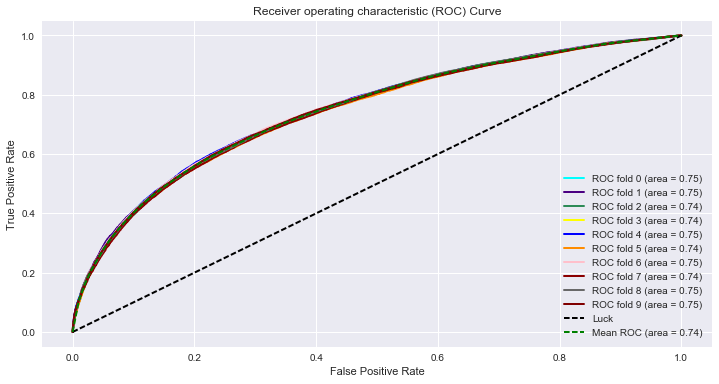

confusion matrix
Predicted   Customer  Subscriber    All
True                                   
Customer       18040        6960  25000
Subscriber      8853       16147  25000
All            26893       23107  50000

Normalized confusion matrix
[[ 0.7216   0.2784 ]
 [ 0.35412  0.64588]]


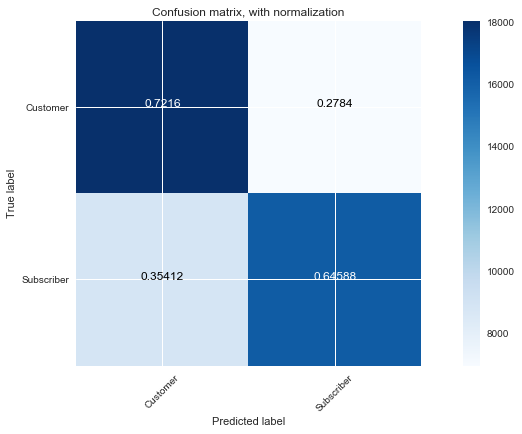

Wall time: 1min 43s


In [51]:
%%time

lr_clf = LogisticRegression(penalty='l2', C=.01, class_weight=None, random_state=seed) # get object

lr_clf = compute_kfold_scores_Classification(clf         = lr_clf,
                                    ScaledData  = myData_scaled_classification
                                   )

##### Random Forest  - Analyze the Results

The next model performed in the previous section, is the Random Forest Classification model. With our tuned parameters identified we may now assess futher insights. The Random Forest Model computes a more successful average accuracy rating of 72.496 %, and an Average Log Loss Value of 9.49958 across all 10 iterations. Once again, plotting our True Positive rate vs. False Positive rate in an ROC curve provides insight depicting consistency across iterations. Our Mean ROC area under the curve for all 10 iterations is 0.80, an improvement from logistic regression. We notice the ROC curve line is slightly further to the top left of the plot - as previously discussed, this is the type of improvement we were looking for! In a confusion matrix of predicted results, we find that we have a true positive rating of 72.272 % for subscriber users, whereas our customer true positive rating is 72.952 %. This provides us with 6762 Customer riders(out of 25,000), which may be flagged as potential targets for conversion marketing to subscribing members. With such an improvement in our true positive subscriber ratings, we have much more confidence in the false positive customer predictions here in comparison to logistic regression results. 

Accuracy Ratings across all iterations: [0.72396, 0.72654, 0.72566, 0.72178, 0.72704, 0.72156, 0.72716, 0.72346, 0.72634, 0.72612]

Average Accuracy: 0.72496

Log Loss Values across all iterations: [9.53419, 9.44508, 9.47548, 9.60949, 9.42781, 9.61709, 9.42367, 9.55146, 9.45199, 9.45959]

Average Log Loss: 9.49958



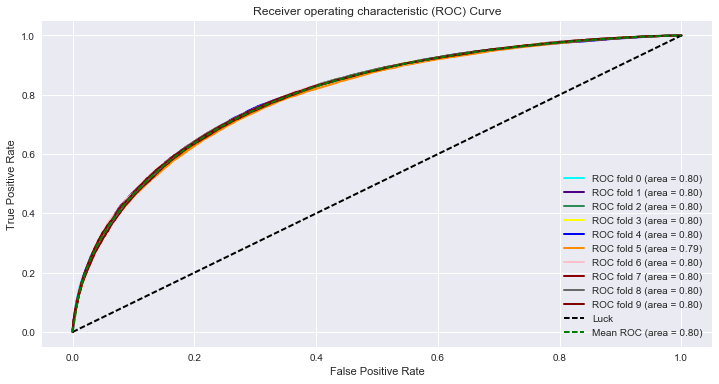

confusion matrix
Predicted   Customer  Subscriber    All
True                                   
Customer       18238        6762  25000
Subscriber      6932       18068  25000
All            25170       24830  50000

Normalized confusion matrix
[[ 0.72952  0.27048]
 [ 0.27728  0.72272]]


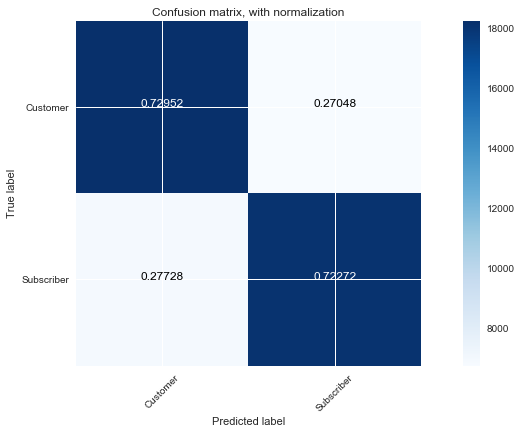

Wall time: 19min


In [52]:
%%time

rfc_clf = RandomForestClassifier(n_estimators       = 15, 
                                 max_features       = 14, 
                                 max_depth          = 1000.0, 
                                 min_samples_split  = 50, 
                                 min_samples_leaf   = 25, 
                                 n_jobs             = -1, 
                                 random_state       = seed) # get object
    
rfc_clf = compute_kfold_scores_Classification(clf         = rfc_clf,
                                    ScaledData  = myData_scaled_classification
                                   )

##### K Nearest Neighbors (KNN) - Analyze the Results

Finally, the last classification model performed is the K Nearest Neighbors Classification model. With our tuned parameters identified we may now assess futher insights. The KNN Model computes an average accuracy rating of 69.554 %, and an Average Log Loss Value of 10.51565 across all 10 iterations. Although these values are slightly more favorable than logistic regression, they are lacking in comparison to the Random Forest Classifier. Once again, plotting our True Positive rate vs. False Positive rate in an ROC curve provides insight depicting consistency across iterations. We are confident that our test/train methodology is sound while using stratified 10 kfold cross validation. Our Mean ROC area under the curve for all 10 iterations is 0.77, an improvement from logistic regression, but once again less favorable than Random Forest. In a confusion matrix of predicted results, we find that we have a true positive rating of 67.464 % for subscriber users, whereas our customer true positive rating is 71.884 %. This provides us with 7029 Customer riders(out of 25,000), which may be flagged as potential targets for conversion marketing to subscribing members. Given knowledge of the previous two models these results are worrysome, as this model produces the largest false positive rating for customers, while still remaining fairly low true positive subscriber rating. Although true positive subscriber rating is higher than that of logistic regression, we will be hesitant with moving forward with this model.

Accuracy Ratings across all iterations: [0.69616, 0.69708, 0.69598, 0.69316, 0.6968, 0.69154, 0.69772, 0.69354, 0.69672, 0.69674]

Average Accuracy: 0.69554

Log Loss Values across all iterations: [10.49438, 10.4626, 10.50059, 10.59799, 10.47227, 10.65395, 10.44049, 10.58487, 10.47503, 10.47434]

Average Log Loss: 10.51565



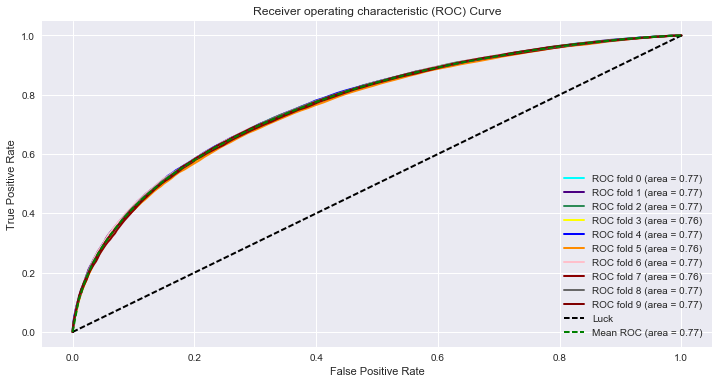

confusion matrix
Predicted   Customer  Subscriber    All
True                                   
Customer       17971        7029  25000
Subscriber      8134       16866  25000
All            26105       23895  50000

Normalized confusion matrix
[[ 0.71884  0.28116]
 [ 0.32536  0.67464]]


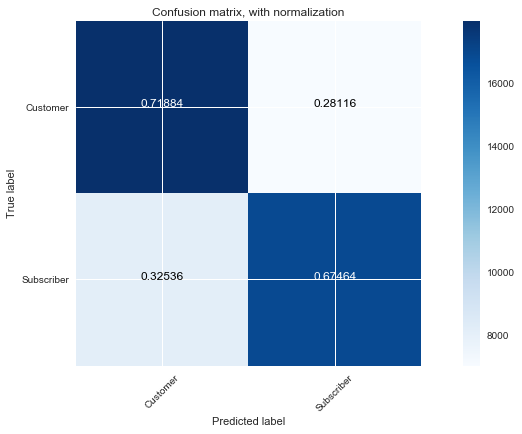

Wall time: 4min


In [53]:
%%time

knn_clf = KNeighborsClassifier(n_neighbors = 150, algorithm = 'kd_tree', leaf_size = 50, n_jobs=-1) # get object

knn_clf = compute_kfold_scores_Classification(clf         = knn_clf,
                                    ScaledData  = myData_scaled_classification
                                   )

#### Regression

Build a function text...


In [54]:
%%time

def compute_kfold_scores_Regression(     clf,  
                                         ScaledData = myData_scaled_regression,
                                         PCA        = pca_regression,
                                         Data       = CitiBikeDataSampled_5050,
                                         cv         = cvReg):
    
    y = Data['tripdurationLog'].values # get the labels we want
    
    X = ScaledData


    # setup pipeline to take PCA, then fit a clf model
    clf_pipe = Pipeline(
        [('PCA',PCA),
         ('CLF',clf)]
    )

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'pink', 'darkred', 'dimgray', 'maroon', 'coral'])

    MSE = []
    r2  = []
    ar2 = []
    
    for (train, test), color in zip(cv.split(X, y), colors):
        clf_pipe.fit(X[train],y[train])  # train object
        y_hat = clf_pipe.predict(X[test]) # get test set preditions
        
        m = float(mt.mean_squared_error(y[test],y_hat))
        r = float(mt.r2_score(y[test], y_hat))
        
        MSE.append(round(m,5)) 
        r2.append(round(r,5))
        
        N = len(y_hat)
        p = 15 # number of components
        ar = 1-(((1-r)*(N-1))/(N-p-1))
        ar2.append(round(ar,5)) 
                
    
    print("Mean Squared Error across all iterations: {0}\n\n\
Average Mean Squared Error: {1}\n\n\
R^2 Values across all iterations: {2}\n\n\
Average R^2: {3}\n\n\
Adjusted R^2 Values across all iterations: {4}\n\n\
Average Adjusted R^2: {5}\n".format(MSE, round(sum(MSE)/len(MSE),5), r2, round(sum(r2)/len(ar2),5), ar2,round(sum(ar2)/len(ar2),5)))
    
       
    #ytestnames = np.where(y[test] == 1, 'Subscriber', 'Customer')
    #yhatnames  = np.where(y_hat == 1, 'Subscriber', 'Customer')
    #print("confusion matrix\n{0}\n".format(pd.crosstab(ytestnames, yhatnames, rownames = ['True'], colnames = ['Predicted'], margins = True)))
        
        # Plot non-normalized confusion matrix
    #plt.figure()
    #plot_confusion_matrix(confusion_matrix(y[test], y_hat), 
    #                      classes   =["Customer", "Subscriber"], 
    #                      normalize =True,
    #                      title     ='Confusion matrix, with normalization')
    
    return clf_pipe.named_steps['CLF']

Wall time: 0 ns


##### KNN Regression - Analyze the Results

In [55]:
%%time

knnr_clf = KNeighborsRegressor(n_neighbors = 100, algorithm = 'kd_tree', leaf_size = 50, n_jobs=-1) # get object
knnr_clf = compute_kfold_scores_Regression(clf = knnr_clf)

Mean Squared Error across all iterations: [0.4864, 0.49134, 0.48142, 0.48295, 0.49105, 0.48498, 0.48481, 0.48059, 0.48742, 0.48639]

Average Mean Squared Error: 0.48574

R^2 Values across all iterations: [0.18604, 0.18576, 0.18607, 0.18906, 0.18447, 0.18429, 0.18743, 0.1917, 0.18581, 0.18361]

Average R^2: 0.18642

Adjusted R^2 Values across all iterations: [0.1858, 0.18552, 0.18583, 0.18881, 0.18423, 0.18404, 0.18719, 0.19145, 0.18556, 0.18336]

Average Adjusted R^2: 0.18618

Wall time: 1min 47s


##### Decision Tree Regression - Analyze the Results

In [56]:
%%time

dtr_clf = DecisionTreeRegressor(splitter           = 'random', 
                                max_features       = 'auto', 
                                max_depth          = None, 
                                min_samples_split  = 80, 
                                min_samples_leaf   = 40, 
                                random_state       = seed) # get object
dtr_clf = compute_kfold_scores_Regression(clf = dtr_clf)

Mean Squared Error across all iterations: [0.49397, 0.4974, 0.48944, 0.48932, 0.49713, 0.49288, 0.49059, 0.48804, 0.49485, 0.49317]

Average Mean Squared Error: 0.49268

R^2 Values across all iterations: [0.17337, 0.17571, 0.1725, 0.17836, 0.17436, 0.171, 0.17774, 0.17917, 0.17339, 0.17223]

Average R^2: 0.17478

Adjusted R^2 Values across all iterations: [0.17312, 0.17546, 0.17225, 0.17811, 0.17411, 0.17075, 0.17749, 0.17893, 0.17314, 0.17198]

Average Adjusted R^2: 0.17453

Wall time: 53.6 s


##### Multi-Layer Perceptron Regression - Analyze the Results

In [57]:
%%time

mlp_clf = MLPRegressor(hidden_layer_sizes = 14, 
                       alpha              = .05,
                       batch_size         = 500,
                       max_iter           = 20,
                       learning_rate_init = .001,
                       random_state       = seed
                      ) # get object
mlp_clf = compute_kfold_scores_Regression(clf = mlp_clf)

D:\Program Files\EXE Files\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Mean Squared Error across all iterations: [0.4925, 0.49722, 0.48947, 0.48882, 0.497, 0.49084, 0.49044, 0.48796, 0.49443, 0.492]

Average Mean Squared Error: 0.49207

R^2 Values across all iterations: [0.17583, 0.17602, 0.17245, 0.17919, 0.17459, 0.17443, 0.17799, 0.17931, 0.17409, 0.17419]

Average R^2: 0.17581

Adjusted R^2 Values across all iterations: [0.17559, 0.17577, 0.1722, 0.17894, 0.17434, 0.17419, 0.17774, 0.17906, 0.17384, 0.17394]

Average Adjusted R^2: 0.17556

Wall time: 1min 59s


## Modeling and Evaluation Part 5 - Discuss the advantages of each model

#### Classification

Who is the Winner????

#### Regression

Who is the Winner????

### Anyone, do research here for python versions of 2ds unit 7.5 material

*XXXXXX If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course. XXXXXX*

In [58]:
from sklearn.cross_validation import cross_val_score
# is clf1 better or worse than clf2?
cv=StratifiedKFold(y,n_folds=10)
acc1 = cross_val_score(lr_clf, X, y=y, cv=cv)
acc2 = cross_val_score(rfc_clf, X, y=y, cv=cv)

NameError: name 'y' is not defined

## Modeling and Evaluation Part 6 - Which attributes from the analysis are most important?
*XXXXXX Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task. XXXXXX*

With our models compared and contrasted, it is time to discuss attribute importance in helping us make our classification and regression predictions. It is important to remember that our variables used were not the original data set features themselves but rather linear combinations of our data constituting our principal components. We will be reviewing the importance of these principal components in our top performing models in the form of model coefficients. The models whose attributes will be reviewed are our Random Forest Classificatino model and KNN KDTree Regression model.

Another facet of attribute importance we will discuss is that of PCA loadings. As mentioned when performing our in depth review of PCA for both prediction tasks, loadings are a means by which we may understand the underlying factors each principal component represents.

These things being said, this section consists of four subsections:

1. Classification PCA Importance
2. Classification PCA Loadings
3. Regression PCA Importance
4. Regression PCA Loadings

##### Classification PCA Importance

When performing our detailed PCA for our Customer/Subscriber classifications earlier, we identified the first 14 components as being all that were necessary to describe 80% of the variance in the classification data set. When generating the random forest model using these 14 principal components as inputs, we generated feature importance values by which our components may be deemed weighted. The larger the value, the greater the component's influence on model response.

The feature importance values for each of our principal components are plotted in the horizontal bar chart below. It is immediately apparent that principal components 1 and 3 are weighted heaviest at about 0.165 and 0.29 respectively. Next largest values are those of principal components 10 (~0.125) and 11 (~0.08). So, among the top four most important features in order are PC3, PC1, PC10, and PC11. The ordering if most important to least important continues with largest to smallest feature importance values. While reviewing our random forest input variables' (principal components in this case) coefficient values is helpful, it does not help us contextually understand the significance of our original attributes. For this reason, it is important to follow up with a review and interpretation of our most important principal components' loadings.

In [ ]:
%%time

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)

idx = ['PC'+str(i) for i in range(1,15)]

plt.barh(range(len(rfc_clf.feature_importances_)), rfc_clf.feature_importances_, color = 'DarkTurquoise')
plt.show()

##### Classification PCA Loadings

Now at the individual principal component level, each classification principal component has 89 loadings which may be esteemed as weights or coefficients representing each original attribute. These loadings represent to what extent each attribute fabricates a given principal component, and the relationship between these attributes in context of the principal component under review. Another perspective is that each principal component is describing an underlying factor which is comprised of the heaviest loadings.

Rather than discuss all 14 principal components, we will instead focus on the four principal components with the largest positive coefficients (PC3, PC1, PC10, and PC11) as described in the feature importance plot above.

*Principal Component 3 - Early Birds, Saturdays, and General Travel Days/Times *

The 3rd principal component, and component with the largest positive coefficient in the logistic regression model, seems to mostly describe the relationship between day of the week and time of the day and how it relates to rider type. Given PC3's large positive coefficient value in the model, it is interesting to see the negative correlation between Saturday rides (-0.58) and Morning rides (0.58). We could hypothesize that if riders are spending their time riding during the morning hours (5am-10am), they are commuting more for work than they are weekend joy riding. Supporting this arguement are the modest positive loadings for the weekdays and the negative loading for Sunday as well. Interestingly enough however, evening, midday, and afternoon rides are also negatively loaded. While more midday and afternoon riding among Customer vs. Subscribers might be expected, the negative loading for evening riding is a bit of a surprise. It would be good to keep an eye on this attribute's loading in the other principal components as well.

Note that while the general signs are arbitrary from one principal component to the next, the sign relationship between attribute loadings within the same principal component are important.

In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=10) 

weightsplot = pd.Series(pca_class.components_[2], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Tomato')
plt.show()

*Principal Component 1 - Peak vs. Non Peak Commute Times*

The first principal component appears to describe the relationships between peak vs. non-peak ride times when people would likely be riding for commutes between work and home vs. leisure rides midday, afternoon, and on the weekends. Specifically, evening rides have a very high loading value around 0.83 while midday and afternoon have values around -0.36 and -0.35 respectively. While the signs in general are not important from one principal component to the next, the sign relationship between attribute loadings within a component are important. In the case of PC1 it would seem that midday and afternoon ride times are negatively correlated with evening ride times. This is an interesting but expected relationship that would suggest midday, afternoon, and evening ride behaviors (the original TimeOfDay attribute in general really) are important attributes.

In [ ]:
weightsplot = pd.Series(pca_class.components_[0], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'DarkRed')
plt.show()

*Principal Component 10 - Environmental Conditions and the Days of the Week / Time of Day*

We admit we were excited to see the influence of weather on Customer/Subscriber classifications via PC10. Min, max, and average temperatures appear to play a significant role in determining who is a Subscriber and who is only a Customer (temperature loadings approximately -0.50 to -0.51). Not only are the strong negative temperature loadings interesting, but they are negatively correlated with Saturday and Sunday activity (~0.15 and 0.205 respectively). This might suggest that, for example, as the temperature outside increases, subscriber activity decreases on the weekends but increases weekdays (except Fridays). Not only that but night time Subscriber activity (loading of approximately -0.16) increases as well. Remember, the overall signs are arbitrary while signed relationships between attributes are important.

In [ ]:
weightsplot = pd.Series(pca_class.components_[9], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'DeepSkyBlue')
plt.show()

*Principal Component 11 - Location*

Our team was also happy to see that our observations from Lab 1 visualizations were correct regarding start and end station locations given the loadings of the 11th principal component. This component clearly portrays very large loadings for start and end station latitudes in excess of -0.6 with the next largest loadings being for start/end station longitudes (loadings around -0.25). This means that riders who are subscribers, for example, are more likely to use stations with larger latitudes (further north in the region) and more positive longitudes (further east in the region) than Customers. Based on what we know about the mid and lower Manhattan areas of NYC and what we observed during Lab 1, we can hypothesize that location is indeed important because of the reasons driving riders to use the CitiBike system. In Lab 1, our heatmaps indicated that customer activity wasn't really centralized to any particular region besides a small concentration at the Central Park Zoo station, whereas subscribers exhibited heavy concentrations throughout the mid and Northeast areas of the region. Notable also is that individual stations also exhibit positive and negative loadings corresponding well with the latitude and longitude loadings.

In [ ]:
weightsplot = pd.Series(pca_class.components_[10], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'SlateBlue')
plt.show()

So to summarize, we believe our most important attributes, in order, for classification are those related to day of the week, time of day, weather, and location for the reasons described previously.

## DELETE REMAINING PCA LOADING SECTIONS FOR CLASSIFICATION

*Principal Component 4 - Leisure vs. Purpose-Centered Weekend Rides*

PC4 is unique in that it requires a respectable amount of domain knowledge to interpret correctly. The most notable loadings are Saturday's 0.6 and Sunday's approximately -0.76 loadings. These are in direct contrast to one another but both occur on the weekend. Noteworthy is also the fact that Morning riding (~0.21) is positively correlated with Saturday riding this time (It was negatively correlated in PC3, but that PC compared weekend vs. weekday riding whereas PC4 focuses primarily on the weekend alone). We might hypothesize that Subscribers might still use the bike share system on Saturdays to run errands, some of which may tend to take place earlier in the day, while Customers tend to joy ride on Sundays, a day when many people tend to relax and take part in recreational activities and other amusements. What isn't surprising is that the day of the week still plays a signficant role in predicting Subscribers vs. Customers.

In [ ]:
weightsplot = pd.Series(pca_class.components_[3], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Orange')
plt.show()

*Principal Component 8 - Beginning vs. End of the Week*

The last principal component for which we will be discussing loadings is PC8. Unlike the previous three PCs reviewed, this component had a negative coefficient in the logistic regression model. The contrast in Tuesday (approximately -0.5) and Thursday (~0.62) loadings is a bit perplexing at first glance. When taking into account the other days of the week and even time of day, however, it's easier to put these relationships into perspective. For example, Thursdays through Sundays all have positive loadings whereas Mondays through Wednesdays all have negative loadings. Accompanying these day of the week correlations are time of day. Given this first half of the work week vs. second half relationship it would appear that individuals riding more in the beginning of the week ride more midday, afternoon, and evening than those riding late in the week and on the weekends. Those individuals might tend to ride more in the morning (Thursdays especially) and at night.

In [ ]:
weightsplot = pd.Series(pca_class.components_[7], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Green')
plt.show()

*Principal Component 2 - Lunch and Afternoon Rides*

In [ ]:
weightsplot = pd.Series(pca_class.components_[1], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Red')
plt.show()

*Principal Component 5 - TGIF*

In [ ]:
weightsplot = pd.Series(pca_class.components_[4], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Gold')
plt.show()

*Principal Component 6 - Monday Go Getters, Mid-Week Hump, and Morning Riders*

In [ ]:
weightsplot = pd.Series(pca_class.components_[5], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Yellow')
plt.show()

*Principal Component 7 - Mid-Week Madness*

In [ ]:
weightsplot = pd.Series(pca_class.components_[6], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Lime')
plt.show()

*Principal Component 8 - T Days*

*Principal Component 9 - *

In [ ]:
weightsplot = pd.Series(pca_class.components_[8], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'RoyalBlue')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_class.components_[11], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Indigo')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_class.components_[12], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'DarkOrchid')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_class.components_[13], index=class_att.columns)
weightsplot.plot(kind='bar', color = 'Magenta')
plt.show()

##### Regression PCA Loadings



In [ ]:
weightsplot = pd.Series(pca_reg.components_[0], index=reg_att.columns)
weightsplot.plot(kind='bar', color = 'DarkRed')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[1], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Red')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[2], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Tomato')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[3], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Orange')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[4], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Gold')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[5], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Yellow')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[6], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Lime')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[7], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Green')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[8], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'RoyalBlue')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[9], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'DeepSkyBlue')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[10], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'SlateBlue')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[11], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Indigo')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[12], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'DarkOrchid')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[13], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Magenta')
plt.show()

In [ ]:
weightsplot = pd.Series(pca_reg.components_[14], index=lr_variable_names)
weightsplot.plot(kind='bar', color = 'Gray')
plt.show()

## Deployment

##### How useful is the model for interested parties?
*XXXXXX (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? XXXXXX*

## Exceptional Work

This lab was the most challenging and time consuming yet, partly because we chose to implement PCA in order to reduce the dimensionality of our data set and partly because we chose to explore new model types such as Neural Networks MLP Regression for trip duration prediction. The additional research and work put toward these records seemed to balloon at times, especially when considering MLP interpretations and ranking attributes through the haze of PCA's linear combinations. We hope, however, that our efforts did not go unnoticed given the added time we spent ensuring we utilized and interpreted these tools correctly.

# Old Work for Reuse. Please Delete this later

### LR Feature Weightings Explained

With our model settled upon for our Logistic Regression, we need to explore the weights associated with each feature to get an idea of how each component impacts the ultimate prediction. Looking at our logistic model directly, we found, interestingly enough, that the highest weight was placed on the latitude of the station where renters began their trips. Having a high positive weight means that subscribers were more likely located at lower latitudes, but based on our heat maps, this seemed to contradict our initial data exploration. Moreover, the next highest weight in terms of magnitude was a specific station, and while it appeared in the top ten percent of our most visited stations, it's odd that it would be so important.

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=10) 

lr_weights_raw = lr_clf_RemABYG.coef_.T # take transpose to make a column vector
lr_variable_names = CitiBikeDataSampled_5050.drop(['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year'], axis = 1).columns
lr_weights = zip(lr_weights_raw,lr_variable_names)

lr_weights_top_15_sorted = sorted(lr_weights, key=lambda x: abs(x[0]), reverse=True)[:15]

lr_weights_top_15_sorted_coef = []
lr_weights_top_15_sorted_names = []
for coef, name in lr_weights_top_15_sorted:
    lr_weights_top_15_sorted_coef.append(coef[0])
    lr_weights_top_15_sorted_names.append(name)

weightsplot = pd.Series(lr_clf_RemABYG.coef_[0], index=lr_variable_names)
weightsplot.plot(kind='bar')
plt.show()
    


In [ ]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

top_15_weights_plot = pd.Series(lr_weights_top_15_sorted_coef, index=lr_weights_top_15_sorted_names)
top_15_weights_plot.plot(kind='bar')
plt.show()


#for coef, name in zip(lr_weights_raw,lr_variable_names):
#    print(name, 'has weight of', coef[0])

After reviewing our dataset once more, we realized that it was likely our weights were compromised due to the fact that we were dealing with a mix of values and quantities that weren't directly comparable. To get a better understanding of how these features were interacting, we decided to attempt to normalize the features, improving our ability to compare these features across their vastly different scales.

This required a refit using the sklearn Standard Scaler training object, but because we're only concerned with the weights and their interactions, we can easily reuse the sets defined in our ShuffleSplit earlier in our regression. However, because we're dealing with scaled and normalized values, we'll use a lower cost value, in this case 0.05 to reflect the expected decrease in variance.

In [ ]:
from sklearn.preprocessing import StandardScaler

matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=10) 

scl_obj = StandardScaler()
scl_obj.fit(X_Train_RemABYG)

X_train_scaled = scl_obj.transform(X_Train_RemABYG)
X_test_scaled = scl_obj.transform(x_Test_RemABYG)

scalar_lr_clf = LogisticRegression(penalty='l2', C=0.05) # Earlier this cost was 1.0, because we've normalized the dataset, we now can use a lower cost
scalar_lr_clf.fit(X_train_scaled,y_Train_RemABYG)

scalar_y_hat = scalar_lr_clf.predict(X_test_scaled)

scalar_acc = mt.accuracy_score(y_Test_RemABYG, y_hat_RemABYG)
scalar_conf = mt.confusion_matrix(y_Test_RemABYG, y_hat_RemABYG)
print('accuracy:', scalar_acc)
print(scalar_conf)


scalar_weights = zip(scalar_lr_clf.coef_[0],lr_variable_names)

scalar_weights_top_15_sorted = sorted(scalar_weights, key=lambda x: abs(x[0]), reverse=True)[:15]

scalar_weights_top_15_sorted_coef = []
scalar_weights_top_15_sorted_names = []
for coef, name in scalar_weights_top_15_sorted:
    scalar_weights_top_15_sorted_coef.append(coef)
    scalar_weights_top_15_sorted_names.append(name)

scalar_weights = pd.Series(scalar_lr_clf.coef_[0],index=lr_variable_names)
scalar_weights.plot(kind='bar')
plt.show()


The accuracy and prediction matrix closely resembles our earlier regression and SVM models, meaning that the act of normalization did not greatly impact our model, however it did make understanding the weights much easier and, surprisingly, closely resembled some of our previous hypotheses we posited during our inital data gathering.

Perhaps one unique component of these new weights is that the log transform of the trip duration has a negative weight, nearly 1, with the subscriber class. This implies that subscribers spend very little time on their trip, despite the linear distance between stations having a high positive weight. These two features seem to correlate with our earlier observations that subscribers were typically seen commuting rather than touring using the bikes.

Another interesting aspect is the temperature component created after merging Citi Bike rental data with historical weather data. Both the maximum temperature and the minimum temperature have a negative weight with the subscriber class, however the average temperature has a positive weight. If subscribers are commuting, then it might make sense that as the average temperature for the day rises, they're much more likely to make use of their subscription. As it's possible they commute regardless of weather, extreme weathers are not as likely to impact their riding habits and behaviors.

Finally, a few more quick observations based entirely on weight - saturday and sunday rentals both have negative weights in relationship to subscribers, further building upon the idea that subscribers are also generally commuters, and mornings also have a positive weight in regards to subscriber use. This might mean that subscribers are more likely to ride earlier in the morning on weekdays.

In [ ]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

scalar_top_15_weights_plot = pd.Series(scalar_weights_top_15_sorted_coef, index=scalar_weights_top_15_sorted_names)
scalar_top_15_weights_plot.plot(kind='bar')
plt.show()

#zip_vars = zip(scalar_lr_clf.coef_.T,lr_variable_names) # combine attributes
#zip_vars = sorted(zip_vars)

#for coef, name in zip_vars:
#    print(name, 'has weight of', coef[0]) # now print them out

### Pros and Cons of LR vs. SVM
Both Logisitic Regression and Support Vector Machines present advantages as well as disadvantages. As might be expected, which approach is best depends on one's data set and problem statement. Our use of both model types with the same data sample set allows us to break down these pros and cons in detail and determine which produces a better fit given our situation. With this in mind, each model type's general advantages and disadvantages are outlined and discussed below.

**General Advantages**

*Logisitic Regression*
- *Simplicity* - The logistic regression model is built in such a way that independent variables are plotted along an x-axis and single-class classification is represented by 0 or 1 on the y-axis. The logit and cost functions are tuned to accurately fit a logistic curve to the data on this x-y plane. By evaluating P(X) via the logit function, we are able to easily determine whether the class is 0 (Customer), in cases when P < 0.5, or 1 (Subscriber), in cases in which P > 0.5. In other words, logistic regression fits all data points as though they were positioned along a continuous function.

- *Small Dimensionality Applications* - Logistic regression works well when there are a smaller number of dimensions and when these attributes do not necessarily determine the response without considering probability of response.

*SVM*
- *Flexible* - Since SVM is capable of fitting a hyperplane among an infinite number of dimensions to create a boundary between classes of various data points, it allows for seperation of data from varying classes even when data sets are very large or contain many attributes.

- *Robust* - In general, SVM is more robust against outliers since it only considers points near the margin as support vectors.

- *Speed (SVM training with Stochastic Gradient Descent)* - Because stochastic gradient descent processes the data in batches and is less precise in it's batch-by-batch approach to deepest descent but still arrives there nonetheless in the end, it is significantly faster than logistic regression and SVM on its own (less resource instensive).

**General Disadvantages**

*Logistic Regression*
- *Speed* - Logistic regression, though faster than straightforward SVM for our data set, is slower in comparison to training a classfier model using stochastic gradient descent.

- *Sensitivity* - In cases when P = ~0.5, logistic regression has difficulty determining classification.

*SVM*
- *Speed (SVM by itself)* - Fitting a SVM model on its own was very slow for our data set. Even after 14 hours of run-time on a quad-core i7 workstation, not even a single model was completely generated.

**The Winner**

Given the general advantages and disadvantages above, we'd now like to discuss both model approaches with respect to our data. These discussions are centered around the data set version in which only Age, Birth Year, and Gender are removed from the originally modeled set. As mentioned above, linear SVM training with stochastic gradient descent for 3x iterations was much faster for our selected data set (~39s) vs. native logistic regression training (~1 min 24s). This time difference is expected to increase exponentially as the number of rides analyzed increases, giving SVM with stochastic gradient descent the upper edge. <span style="color:green">*+1 for SVM with stochastic gradient descent*</span>

On the other hand, however, logistic regression produced accuracy results of {74.52, 74.49, 74.73} % across the three test/train iterations whereas SVM with stochastic gradient descent exhibited accuracy results of {74.121, 74.339, 74.44} %. This slight increase in accuracy among logistic regression models is an interesting observation, especially given logistic regression's added simplicity vs. SVM modelling. A second measure of accuracy employed throughout this analysis has been log-loss. When comparing log-loss among both model types, we expect log-loss values to correspond with model accuracy measures also. As such, logistic regression log-loss values were {8.80, 8.75, 8.73} for each of the three iterations whereas SVM with stochastic gradient values were {8.94, 8.86, 8.83}. As expected, these results correlate with the accuracy scores discussed. <span style="color:blue">*+1 for logistic regression*</span>

The final comparison worth further discussion is that of efficiency. As mentioned in the general advantages and disadvantages above, logistic regression consists of a simpler model than SVM, especially when factoring in stochastic gradient descent to SVM model training. Logistic regression classifies our CitiBike user types by optimizing the log likelihood function; SVM tries to maximize the margin between the closest data points of two classification regions. The fact that stochastic gradient descent is required given our data set dimensions and large number of observations means the model generation process may be deemed less efficient. In the end, the principles of Occam's Razor apply. Therefore, logistic regression without stochastic gradient descent takes the win for our data set.<span style="color:blue">*+1 for logistic regression*</span>

Given its increased accuracy and efficiency/simplicity, we rate logistic regression as being the better model for user type classification using our sample data set of 500,000 rides.